# Individual Project - Shabenoor Kamal - Statistical and ML Methods

## 1. Initiation

In [479]:
Sys.setenv(LANG = "en")

# Data processing library
library(data.table)       # Data manipulation
library(plyr)             # Data manipulation
library(stringr)          # String, text processing
library(vita)             # Quickly check variable importance
library(dataPreparation)  # Data preparation library
library(woeBinning)       # Decision tree–based binning for numerical and categorical variables
library(Boruta)           # Variable selection

# Machine learning library
library(mlr)          # Machine learning framework
library(caret)         # Data processing and machine learning framework
library(MASS)          # LDA
library(randomForest)  # RF
library(gbm)           # Boosting Tree
library(xgboost)       # XGboost

## 2. Data summary and processing

### 2.1. Data summary

#### Read and print out some data

In [481]:
# Read train (full), test (holdout)
train_full <- read.csv('C:/Users/skamal/Downloads/bank_mkt_train.csv')  # Training dataset
test_holdout <- read.csv('C:/Users/skamal/Downloads/bank_mkt_test.csv')  # Holdout data set without response

In [482]:
# Print out to check the data type
str(train_full)

'data.frame':	7000 obs. of  21 variables:
 $ client_id     : int  2 3 4 5 6 7 8 9 14 15 ...
 $ age           : int  29 39 49 32 29 51 34 52 52 29 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 11 2 7 1 7 2 8 1 1 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 3 3 2 2 2 2 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 7 4 7 1 4 7 7 ...
 $ default       : Factor w/ 2 levels "no","unknown": 1 2 2 1 2 2 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 3 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 1 2 1 1 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 7 4 5 8 8 8 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 1 4 2 1 4 4 4 3 2 ...
 $ campaign      : int  3 6 2 3 2 1 1 1 3 1 ...
 $ pdays         : int  999 999 999 999 9

#### Correct the variable: campaign

Since campaign includes also the last contact, its value should be reduce by 1.

In [483]:
# Fix the value
train_full[, 'campaign'] <- train_full[, 'campaign'] - 1
test_holdout[, 'campaign'] <- test_holdout[, 'campaign'] - 1

# Quick check
min(train_full[, 'campaign'])  # Previously = 1
min(test_holdout[, 'campaign'])  # Previously = 1

[1] 0

[1] 0

#### Check and fix data error (if any)

In [484]:
# Check missing value
apply(is.na(train_full), 2, sum)

client_id            age            job        marital      education 
             0              0              0              0              0 
       default        housing           loan        contact          month 
             0              0              0              0              0 
   day_of_week       campaign          pdays       previous       poutcome 
             0              0              0              0              0 
  emp.var.rate cons.price.idx  cons.conf.idx      euribor3m    nr.employed 
             0              0              0              0              0 
     subscribe 
             0

#### Split train (full) data into train, valid, test (70:15:15)

In [485]:
set.seed(1)

train_idx <- caret::createDataPartition(y=train_full[, 'subscribe'], p=.7, list=F)
train <- train_full[train_idx, ]  # Train 70%
valid_test <- train_full[-train_idx, ]  # Valid + Test 30%

valid_idx <- caret::createDataPartition(y=valid_test[, 'subscribe'], p=.5, list=F)
valid <- valid_test[valid_idx, ]  # Valid 15%
test <- valid_test[-valid_idx, ]  # Test 15%

#### Check the target variable class distribution

In [486]:
# By number
table(train$subscribe)
table(valid$subscribe)
table(test$subscribe)


   0    1 
4329  571 


  0   1 
932 118 


  0   1 
917 133 

In [487]:
# By percentage
table(train$subscribe) / nrow(train)
table(valid$subscribe) / nrow(valid)
table(test$subscribe) / nrow(test)


        0         1 
0.8834694 0.1165306 


       0        1 
0.887619 0.112381 


        0         1 
0.8733333 0.1266667 

#### Simply check which variables are potentially important

Note: Running this permutation algorithm may take some time.

In [488]:
# PIMP-Algorithm For The Permutation Variable Importance Measure
# https://cran.r-project.org/web/packages/vita/vita.pdf
X <- train[, 2:(ncol(train)-1)]
y <- as.factor(train[, 'subscribe'])
rf_model <- randomForest(X, y, mtry=3, ntree=100, importance=T, seed=1)
pimp_varImp <- PIMP(X, y, rf_model, S=10, parallel=F, seed=123)

In [489]:
# Print out top most important variables
pimp_varImp$VarImp[order(pimp_varImp$VarImp[, 1], decreasing=T), ]

month      euribor3m   emp.var.rate cons.price.idx  cons.conf.idx 
  4.632988e-02   4.022497e-02   3.931082e-02   3.000087e-02   2.162921e-02 
   nr.employed            job            age       poutcome      education 
  1.920353e-02   7.858357e-03   6.718074e-03   3.726290e-03   3.395204e-03 
         pdays       previous        marital    day_of_week        default 
  2.722571e-03   2.211874e-03   1.069878e-03   1.020343e-03   7.315077e-04 
       contact           loan        housing       campaign 
  6.439186e-04   4.370847e-04   2.465477e-04  -8.371925e-05

### 2.2. Feature engineering


#### Add variable: month_spring

In [490]:
# Add new variable to train, valid, test and test (holdout)
# Train, valid, test
train[, 'month_spring'] <- as.logical(train$month %in% c('mar', 'apr', 'may'))
valid[, 'month_spring'] <- as.logical(valid$month %in% c('mar', 'apr', 'may'))
test[, 'month_spring'] <- as.logical(test$month %in% c('mar', 'apr', 'may'))
# Test (holdout)
test_holdout[, 'month_spring'] <- as.logical(test_holdout$month %in% c('mar', 'apr', 'may'))

#### Add variable: month_summer

In [491]:
# Add new variable to train, valid, test and test (holdout)
# Train, valid, test
train[, 'month_summer'] <- as.logical(train$month %in% c('jun', 'jul', 'aug'))
valid[, 'month_summer'] <- as.logical(valid$month %in% c('jun', 'jul', 'aug'))
test[, 'month_summer'] <- as.logical(test$month %in% c('jun', 'jul', 'aug'))
# Test (holdout)
test_holdout[, 'month_summer'] <- as.logical(test_holdout$month %in% c('jun', 'jul', 'aug'))

#### Add variable: month_autumn

In [492]:
# Add new variable to train, valid, test and test (holdout)
# Train, valid, test
train[, 'month_autumn'] <- as.logical(train$month %in% c('sep', 'oct', 'nov'))
valid[, 'month_autumn'] <- as.logical(valid$month %in% c('sep', 'oct', 'nov'))
test[, 'month_autumn'] <- as.logical(test$month %in% c('sep', 'oct', 'nov'))
# Test (holdout)
test_holdout[, 'month_autumn'] <- as.logical(test_holdout$month %in% c('sep', 'oct', 'nov'))

#### Add variable: month_winter

In [493]:
# Add new variable to train, valid, test and test (holdout)
# Train, valid, test
train[, 'month_winter'] <- as.logical(train$month %in% c('dec', 'jan', 'feb'))
valid[, 'month_winter'] <- as.logical(valid$month %in% c('dec', 'jan', 'feb'))
test[, 'month_winter'] <- as.logical(test$month %in% c('dec', 'jan', 'feb'))
# Test (holdout)
test_holdout[, 'month_winter'] <- as.logical(test_holdout$month %in% c('dec', 'jan', 'feb'))

#### Add variable: age > mean(age)

In [494]:
# Add new variable to train, valid, test and test (holdout)
# Train, valid, test
train[, 'age_ge_mean'] <- as.logical(train$age > mean(train$age))
valid[, 'age_ge_mean'] <- as.logical(valid$age > mean(valid$age))
test[, 'age_ge_mean'] <- as.logical(test$age > mean(test$age))
# Test (holdout)
test_holdout[, 'age_ge_mean'] <- as.logical(test_holdout$age > mean(train$age))

#### Add variable: pdays_999

In [495]:
# Add new variable to train, valid, test and test (holdout)
# pdays == 999 is a special value
# Train, valid, test
train[, 'pdays_999'] <- as.logical(train$pdays == 999)
valid[, 'pdays_999'] <- as.logical(valid$pdays == 999)
test[, 'pdays_999'] <- as.logical(test$pdays == 999)
# Test (holdout)
test_holdout[, 'pdays_999'] <- as.logical(test_holdout$pdays == 999)

### Add new variables

In [496]:
# Add new variable to train, valid, test and test (holdout) - number emplyees >= or < mean
# Train, valid, test
train[, 'nremply_ge_mean'] <- as.logical(train$nr.employed > mean(train$nr.employed))
valid[, 'nremply_ge_mean'] <- as.logical(valid$nr.employed > mean(valid$nr.employed))
test[, 'nremply_ge_mean'] <- as.logical(test$nr.employed > mean(test$nr.employed))
# Test (holdout)
test_holdout[, 'nremply_ge_mean'] <- as.logical(test_holdout$nr.employed > mean(train$nr.employed))

# Add new variable to train, valid, test and test (holdout) - number emplyees >= or < median
# Train, valid, test
train[, 'nremply_ge_median'] <- as.logical(train$nr.employed > median(train$nr.employed))
valid[, 'nremply_ge_median'] <- as.logical(valid$nr.employed > median(valid$nr.employed))
test[, 'nremply_ge_median'] <- as.logical(test$nr.employed > median(test$nr.employed))
# Test (holdout)
test_holdout[, 'nremply_ge_median'] <- as.logical(test_holdout$nr.employed > median(train$nr.employed))


# Add new variable to train, valid, test and test (holdout) - pdays >= or < mean
# Train, valid, test
train[, 'pdays_ge_mean'] <- as.logical(train$pdays > mean(train$pdays))
valid[, 'pdays_ge_mean'] <- as.logical(valid$pdays > mean(valid$pdays))
test[, 'pdays_ge_mean'] <- as.logical(test$pdays > mean(test$pdays))
# Test (holdout)
test_holdout[, 'pdays_ge_mean'] <- as.logical(test_holdout$pdays > mean(train$pdays))

# Add new variable to train, valid, test and test (holdout)- pdays >= or < median
# Train, valid, test
train[, 'pdays_ge_median'] <- as.logical(train$pdays > median(train$pdays))
valid[, 'pdays_ge_median'] <- as.logical(valid$pdays > median(valid$pdays))
test[, 'pdays_ge_median'] <- as.logical(test$pdays > median(test$pdays))
# Test (holdout)
test_holdout[, 'pdays_ge_median'] <- as.logical(test_holdout$pdays > median(train$pdays))

# Add new variable to train, valid, test and test (holdout)
# previous contact == 0 (no contact) >0 (has been contacted before)
# Train, valid, test
train[, 'previous_ever'] <- as.logical(train$previous > 0)
valid[, 'previous_ever'] <- as.logical(valid$previous > 0)
test[, 'previous_ever'] <- as.logical(test$previous > 0)
# Test (holdout)
test_holdout[, 'previous_ever'] <- as.integer(test_holdout$previous > 0)

# Add new variable to train, valid, test and test (holdout)- previous contact days >= or < mean
# Train, valid, test
train[, 'previous_ge_mean'] <- as.logical(train$previous > mean(train$previous))
valid[, 'previous_ge_mean'] <- as.logical(valid$previous > mean(valid$previous))
test[, 'previous_ge_mean'] <- as.logical(test$previous > mean(test$previous))
# Test (holdout)
test_holdout[, 'previous_ge_mean'] <- as.logical(test_holdout$previous > mean(train$previous))

# Add new variable to train, valid, test and test (holdout) - previous contact days >= or < median
# Train, valid, test
train[, 'previous_ge_median'] <- as.logical(train$previous > median(train$previous))
valid[, 'previous_ge_median'] <- as.logical(valid$previous > median(valid$previous))
test[, 'previous_ge_median'] <- as.logical(test$previous > median(test$previous))
# Test (holdout)
test_holdout[, 'previous_ge_median'] <- as.logical(test_holdout$previous > median(train$previous))

# Add new variable to train, valid, test and test (holdout) - employee variation rate (positive/negative)
# Train, valid, test
train[, 'emp_varrate_positive'] <- as.logical(train$emp.var.rate  > 0)
valid[, 'emp_varrate_positive'] <- as.logical(valid$emp.var.rate  > 0)
test[, 'emp_varrate_positive'] <- as.logical(test$emp.var.rate  > 0)
# Test (holdout)
test_holdout[, 'emp_varrate_positive'] <- as.logical(test_holdout$emp.var.rate  > 0)

# Add new variable to train, valid, test and test (holdout)- employee variation rate >= or < mean
# Train, valid, test
train[, 'emp_varrate_ge_mean'] <- as.logical(train$emp.var.rate > mean(train$emp.var.rate))
valid[, 'emp_varrate_ge_mean'] <- as.logical(valid$emp.var.rate > mean(valid$emp.var.rate))
test[, 'emp_varrate_ge_mean'] <- as.logical(test$emp.var.rate > mean(test$emp.var.rate))
# Test (holdout)
test_holdout[, 'emp_varrate_ge_mean'] <- as.logical(test_holdout$emp.var.rate > mean(train$emp.var.rate))

# Add new variable to train, valid, test and test (holdout)- employee variation rate >= or < median
# Train, valid, test
train[, 'emp_varrate_ge_median'] <- as.logical(train$emp.var.rate > median(train$emp.var.rate))
valid[, 'emp_varrate_ge_median'] <- as.logical(valid$emp.var.rate > median(valid$emp.var.rate))
test[, 'emp_varrate_ge_median'] <- as.logical(test$emp.var.rate > median(test$emp.var.rate))
# Test (holdout)
test_holdout[, 'emp_varrate_ge_median'] <- as.logical(test_holdout$emp.var.rate > median(train$emp.var.rate))

# Add new variable to train, valid, test and test (holdout) - consumer price index >= or < mean
# Train, valid, test
train[, 'conspriceindx_ge_mean'] <- as.logical(train$cons.price.idx > mean(train$cons.price.idx))
valid[, 'conspriceindx_ge_mean'] <- as.logical(valid$cons.price.idx > mean(valid$cons.price.idx))
test[, 'conspriceindx_ge_mean'] <- as.logical(test$cons.price.idx > mean(test$cons.price.idx))
# Test (holdout)
test_holdout[, 'conspriceindx_ge_mean'] <- as.logical(test_holdout$cons.price.idx > mean(train$cons.price.idx))

# Add new variable to train, valid, test and test (holdout) - consumer price index  >= or < median
# Train, valid, test
train[, 'conspriceindx_ge_median'] <- as.logical(train$cons.price.idx > median(train$cons.price.idx))
valid[, 'conspriceindx_ge_median'] <- as.logical(valid$cons.price.idx > median(valid$cons.price.idx))
test[, 'conspriceindx_ge_median'] <- as.logical(test$cons.price.idx > median(test$cons.price.idx))
# Test (holdout)
test_holdout[, 'conspriceindx_ge_median'] <- as.logical(test_holdout$cons.price.idx > median(train$cons.price.idx))

# Add new variable to train, valid, test and test (holdout)- month in quarter 1 of year
# Train, valid, test
train[, 'month_quarter1'] <- as.logical(train$month %in% c('jan', 'feb', 'mar'))
valid[, 'month_quarter1'] <- as.logical(valid$month %in% c('jan', 'feb', 'mar'))
test[, 'month_quarter1'] <- as.logical(test$month %in% c('jan', 'feb', 'mar'))
# Test (holdout)
test_holdout[, 'month_quarter1'] <- as.logical(test_holdout$month %in% c('jan', 'feb', 'mar'))

# Add new variable to train, valid, test and test (holdout) - month in quarter 2 of year
# Train, valid, test
train[, 'month_quarter2'] <- as.logical(train$month %in% c('apr', 'may', 'jun'))
valid[, 'month_quarter2'] <- as.logical(valid$month %in% c('apr', 'may', 'jun'))
test[, 'month_quarter2'] <- as.logical(test$month %in% c('apr', 'may', 'jun'))
# Test (holdout)
test_holdout[, 'month_quarter2'] <- as.logical(test_holdout$month %in% c('apr', 'may', 'jun'))

# Add new variable to train, valid, test and test (holdout) - month in quarter 3 of year
# Train, valid, test
train[, 'month_quarter3'] <- as.logical(train$month %in% c('jul', 'aug', 'sep'))
valid[, 'month_quarter3'] <- as.logical(valid$month %in% c('jul', 'aug', 'sep'))
test[, 'month_quarter3'] <- as.logical(test$month %in% c('jul', 'aug', 'sep'))
# Test (holdout)
test_holdout[, 'month_quarter3'] <- as.logical(test_holdout$month %in% c('jul', 'aug', 'sep'))

# Add new variable to train, valid, test and test (holdout)- month in quarter 4 of year
# Train, valid, test
train[, 'month_quarter4'] <- as.logical(train$month %in% c('oct', 'nov', 'dec'))
valid[, 'month_quarter4'] <- as.logical(valid$month %in% c('oct', 'nov', 'dec'))
test[, 'month_quarter4'] <- as.logical(test$month %in% c('oct', 'nov', 'dec'))
# Test (holdout)
test_holdout[, 'month_quarter4'] <- as.logical(test_holdout$month %in% c('oct', 'nov', 'dec'))

### 2.3. Processing data

#### 2.3.1. Value transformation

- Categorical variables: remapping
- Continuous variables: discretization

Reference:  

Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

#### Get the list of categorical, boolean and numerical variables

In [497]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [498]:
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

#### Grouping (or remapping) categorical variables - Decision tree–based remapping

Reference:  

Package ‘woeBinning’: https://cran.r-project.org/web/packages/woeBinning/woeBinning.pdf

Test the variable remmaping on a categorical variable.

In [499]:
# Grouping 12 categories in the variable job onto 3 groups using WOE
binning_cat <- woe.binning(train, 'subscribe', 'job')
binning_cat

,Group.2,Group.1,woe,iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
3,misc. level neg. + technician + blue-collar + services,blue-collar,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
4,misc. level neg. + technician + blue-collar + services,entrepreneur,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
5,misc. level neg. + technician + blue-collar + services,housemaid,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
6,misc. level neg. + technician + blue-collar + services,services,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
7,misc. level neg. + technician + blue-collar + services,technician,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
8,misc. level neg. + technician + blue-collar + services,unknown,-31.13043,0.1344354,237,2453,0.4150613,0.5666436,0.04718821
1,admin. + management,admin.,10.05149,0.1344354,202,1385,0.3537653,0.3199353,0.00340042
2,admin. + management,management,10.05149,0.1344354,202,1385,0.3537653,0.3199353,0.00340042
9,misc. level pos.,retired,71.20604,0.1344354,132,491,0.2311734,0.1134211,0.08384673
10,misc. level pos.,self-employed,71.20604,0.1344354,132,491,0.2311734,0.1134211,0.08384673


In [500]:
# Apply the binning to data
tmp <- woe.binning.deploy(train, binning_cat, add.woe.or.dum.var='woe')
head(tmp[, c('job', 'job.binned', 'woe.job.binned')])

,job,job.binned,woe.job.binned
1,housemaid,misc. level neg. + technician + blue-collar + services,-31.13043
3,blue-collar,misc. level neg. + technician + blue-collar + services,-31.13043
4,self-employed,misc. level pos.,71.20604
6,self-employed,misc. level pos.,71.20604
7,blue-collar,misc. level neg. + technician + blue-collar + services,-31.13043
14,technician,misc. level neg. + technician + blue-collar + services,-31.13043


Apply the variable remmaping for all categorical variables.

In [501]:
# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Remapping categorical variable on train data
    binning_cat <- woe.binning(train, 'subscribe', v)
    
    # Apply the binning to the train, valid and test data
    train <- woe.binning.deploy(train, binning_cat, add.woe.or.dum.var='woe')
    valid <- woe.binning.deploy(valid, binning_cat, add.woe.or.dum.var='woe')
    test <- woe.binning.deploy(test, binning_cat, add.woe.or.dum.var='woe')
    
    # Apply the binning to the test (holdout) data
    test_holdout <- woe.binning.deploy(test_holdout, binning_cat, add.woe.or.dum.var='woe')
}

#### Grouping (or discretizing) numerical variables - Decision tree–based discretization

Test the variable discretizing on a numerical variable.

In [502]:
# Grouping the variable age onto 4 groups using WOE
binning_num <- woe.binning(train, 'subscribe', 'age')
binning_num

,woe,cutpoints.final,cutpoints.final[-1],iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
"(-Inf,26]",58.096468,-Inf,26,0.1508385,54,229,0.09457093,0.05289905,0.0242098877
"(26,37]",3.963093,26,37,0.1508385,251,1829,0.43957968,0.42249942,0.0006769067
"(37,55]",-40.499981,37,55,0.1508385,169,1921,0.29597198,0.44375144,0.0598506552
"(55, Inf]",74.248046,55,Inf,0.1508385,97,350,0.16987741,0.08085008,0.0661010510
Missing,NA,Inf,Missing,0.1508385,0,0,0.00000000,0.00000000,NA


In [503]:
# Apply the binning to data
tmp <- woe.binning.deploy(train, binning_num, add.woe.or.dum.var='woe')
head(tmp[, c('age', 'age.binned', 'woe.age.binned')])

,age,age.binned,woe.age.binned
1,29,"(26,37]",3.963093
3,49,"(37,55]",-40.499981
4,32,"(26,37]",3.963093
6,51,"(37,55]",-40.499981
7,34,"(26,37]",3.963093
14,39,"(37,55]",-40.499981


Apply the variable discretizing for all numerical variables.

In [504]:
# Loop through all numerical variables
for (v in iv_num_list) {
    
    # Discretizing numerical variable on train data
    binning_num <- woe.binning(train, 'subscribe', v)
    
    # Apply the binning to the train, valid and test data
    train <- woe.binning.deploy(train, binning_num, add.woe.or.dum.var='woe')
    valid <- woe.binning.deploy(valid, binning_num, add.woe.or.dum.var='woe')
    test <- woe.binning.deploy(test, binning_num, add.woe.or.dum.var='woe')
    
    # Apply the binning to the test (holdout) data
    test_holdout <- woe.binning.deploy(test_holdout, binning_num, add.woe.or.dum.var='woe')
}

#### Grouping (or discretizing) numerical variables - Equal frequency discretization

Reference:  

Tutorial to prepare train and test set using dataPreparation: https://cran.r-project.org/web/packages/dataPreparation/vignettes/train_test_prep.html

Test the variable discretizing on a numerical variable.

In [505]:
# Build the discretization
bins <- build_bins(dataSet=train, cols="age", n_bins=5, type="equal_freq", verbose=F)

# Print out to check
bins

$age
[1] -Inf   31   35   41   50  Inf

In [506]:
# Apply to the data
tmp <- fastDiscretization(dataSet=train, bins=bins, verbose=F)
setDF(tmp); setDF(train)  # Convert data.table to data.frame
head(tmp[, 'age'])

[1] ]-Inf, 31[ [41, 50[   [31, 35[   [50, +Inf[ [31, 35[   [35, 41[  
Levels: [31, 35[ [35, 41[ [41, 50[ [50, +Inf[ ]-Inf, 31[

Apply the variable discretizing for all numerical variables.

In [507]:
# Loop through all numerical variables
for (v in iv_num_list) {
    
    # Discretizing numerical variable on train data, n_bins=5
    bins <- build_bins(dataSet=train, cols=v, n_bins=5, type="equal_freq", verbose=F)
    
    # Apply the binning to the train, valid and test data
    tmp <- fastDiscretization(dataSet=train, bins=bins, verbose=F)
    setDF(tmp); setDF(train)  # Convert data.table to data.frame
    train[, paste0(v, '_freq_bin')] <- tmp[, v]  # Add new variable
    
    tmp <- fastDiscretization(dataSet=valid, bins=bins, verbose=F)
    setDF(tmp); setDF(valid)  # Convert data.table to data.frame
    valid[, paste0(v, '_freq_bin')] <- tmp[, v]  # Add new variable
    
    tmp <- fastDiscretization(dataSet=test, bins=bins, verbose=F)
    setDF(tmp); setDF(test)  # Convert data.table to data.frame
    test[, paste0(v, '_freq_bin')] <- tmp[, v]  # Add new variable
    
    # Apply the binning to the test (holdout) data
    tmp <- fastDiscretization(dataSet=test_holdout, bins=bins, verbose=F)
    setDF(tmp); setDF(test_holdout)  # Convert data.table to data.frame
    test_holdout[, paste0(v, '_freq_bin')] <- tmp[, v]  # Add new variable
}

#### Grouping (or discretizing) numerical variables - Equal width discretization

Test the variable discretizing on a numerical variable.

In [508]:
# Build the discretization
bins <- build_bins(dataSet=train, cols="age", n_bins=5, type="equal_width", verbose=F)

# Print out to check
bins

$age
[1] 19.0 32.8 46.6 60.4 74.2 88.0

In [509]:
# Apply to the data
tmp <- fastDiscretization(dataSet=train, bins=bins, verbose=F)
setDF(tmp); setDF(train)  # Convert data.table to data.frame
head(tmp[, 'age'])

[1] [19, 32.8[   [46.6, 60.4[ [19, 32.8[   [46.6, 60.4[ [32.8, 46.6[
[6] [32.8, 46.6[
Levels: [19, 32.8[ [32.8, 46.6[ [46.6, 60.4[ [60.4, 74.2[ [74.2, 88]

Apply the variable discretizing for all numerical variables.

In [510]:
# Loop through all numerical variables
for (v in iv_num_list) {
    
    # Discretizing numerical variable on train data, n_bins=5
    bins <- build_bins(dataSet=train, cols=v, n_bins=5, type="equal_width", verbose=F)
    
    # Apply the binning to the train, valid and test data
    tmp <- fastDiscretization(dataSet=train, bins=bins, verbose=F)
    setDF(tmp); setDF(train)  # Convert data.table to data.frame
    train[, paste0(v, '_width_bin')] <- tmp[, v]  # Add new variable
    
    tmp <- fastDiscretization(dataSet=valid, bins=bins, verbose=F)
    setDF(tmp); setDF(valid)  # Convert data.table to data.frame
    valid[, paste0(v, '_width_bin')] <- tmp[, v]  # Add new variable
    
    tmp <- fastDiscretization(dataSet=test, bins=bins, verbose=F)
    setDF(tmp); setDF(test)  # Convert data.table to data.frame
    test[, paste0(v, '_width_bin')] <- tmp[, v]  # Add new variable
    
    # Apply the binning to the test (holdout) data
    tmp <- fastDiscretization(dataSet=test_holdout, bins=bins, verbose=F)
    setDF(tmp); setDF(test_holdout)  # Convert data.table to data.frame
    test_holdout[, paste0(v, '_width_bin')] <- tmp[, v]  # Add new variable
}

#### 2.3.2. Value representation

- Dummy coding
- Incidence replacement
- Weight of evidence (WoE conversion)

Reference:  

Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

All about Categorical Variable Encoding: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

#### Get the updated list of categorical, boolean and numerical variables

In [511]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [512]:
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

#### Convert categorical variables to dummy

Test the variable representation on a categorical variable.

In [513]:
# Build the dummy encoding
encoding <- build_encoding(dataSet=train, cols="job", verbose=F)

In [514]:
# Transform the categorical variable
tmp <- one_hot_encoder(dataSet=train, encoding=encoding, type='logical', drop=F, verbose=F)
setDF(tmp)
tmp <- tmp[, -ncol(tmp)]
head(tmp[, 84:ncol(tmp)])

age_freq_bin,campaign_freq_bin,pdays_freq_bin,previous_freq_bin,emp.var.rate_freq_bin,cons.price.idx_freq_bin,cons.conf.idx_freq_bin,euribor3m_freq_bin,nr.employed_freq_bin,age_width_bin,...,job.blue.collar,job.entrepreneur,job.housemaid,job.management,job.retired,job.self.employed,job.services,job.student,job.technician,job.unemployed
"]-Inf, 31[","[2, +Inf[","[999, +Inf[","[0, +Inf[","[1.1, 1.4[","[93.994, +Inf[","[-36.4, +Inf[","[4.153, 4.864[","[5191, 5195.8[","[19, 32.8[",...,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
"[41, 50[","[1, 2[","[999, +Inf[","[0, +Inf[","[-0.1, 1.1[","[92.963, 93.444[","[-42, -39.8[","[4.153, 4.864[","[5195.8, 5228.1[","[46.6, 60.4[",...,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
"[31, 35[","[2, +Inf[","[999, +Inf[","[0, +Inf[","[-1.8, -0.1[","]-Inf, 92.963[","[-46.2, -42[","[1.291, 4.153[","[5099.1, 5191[","[19, 32.8[",...,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
"[50, +Inf[","[0, 1[","[999, +Inf[","[0, +Inf[","[1.4, +Inf[","[93.994, +Inf[","[-42, -39.8[","[4.864, 4.962[","[5228.1, +Inf[","[46.6, 60.4[",...,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
"[31, 35[","[0, 1[","[999, +Inf[","[0, +Inf[","[-0.1, 1.1[","[92.963, 93.444[","[-42, -39.8[","[4.153, 4.864[","[5195.8, 5228.1[","[32.8, 46.6[",...,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
"[35, 41[","[0, 1[","[999, +Inf[","[0, +Inf[","[1.4, +Inf[","[93.444, 93.918[","[-36.4, +Inf[","[4.962, +Inf[","[5228.1, +Inf[","[32.8, 46.6[",...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE


Apply the variable representation for all categorical variables.

In [515]:
# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Representing categorical variable on train data
    encoding <- build_encoding(dataSet=train, cols=v, verbose=F)
    
    # Apply the binning to the train, valid and test data
    train <- one_hot_encoder(dataSet=train, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(train)
    train <- train[, -ncol(train)]  # Drop the last dummy column
    
    valid <- one_hot_encoder(dataSet=valid, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(valid)
    valid <- valid[, -ncol(valid)]  # Drop the last dummy column
    
    test <- one_hot_encoder(dataSet=test, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(test)
    test <- test[, -ncol(test)]  # Drop the last dummy column
    
    # Apply the binning to the test (holdout) data
    test_holdout <- one_hot_encoder(dataSet=test_holdout, encoding=encoding, type='logical', drop=F, verbose=F)
    setDF(test_holdout)
    test_holdout <- test_holdout[, -ncol(test_holdout)]  # Drop the last dummy column
}

#### Represent categorical variables using incidence of target variable

Test the variable representation on a categorical variable.

In [516]:
# Find the incidence rates per category of a variable
tb <- table(train$job, train$subscribe)
incidence_map <- data.frame('v1'=rownames(tb), 'v2'=tb[, '1'] / (tb[, '0'] + tb[, '1']))
colnames(incidence_map) <- c('job', 'job_incidence')
incidence_map

,job,job_incidence
admin.,admin.,0.12975207
blue-collar,blue-collar,0.08388313
entrepreneur,entrepreneur,0.10695187
housemaid,housemaid,0.10937500
management,management,0.11936340
retired,retired,0.24778761
self-employed,self-employed,0.13888889
services,services,0.07578947
student,student,0.31775701
technician,technician,0.09506173


In [517]:
# Convert the categories with incidences
tmp <- plyr::join(x=train, y=incidence_map, by='job', type="left", match="all")  # Left join
head(tmp[, c('job', 'job_incidence')])

job,job_incidence
housemaid,0.10937500
blue-collar,0.08388313
self-employed,0.13888889
self-employed,0.13888889
blue-collar,0.08388313
technician,0.09506173


Apply the variable representation for all categorical variables.

In [518]:
# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Find the incidence rates per category of a variable
    tb <- table(train[, v], train[, 'subscribe'])
    incidence_map <- data.frame('v1'=rownames(tb), 'v2'=tb[, '1'] / (tb[, '0'] + tb[, '1']))
    colnames(incidence_map) <- c(v, paste0(v, '_incidence'))  # Rename the columns to join
    
    # Apply the variable representation to the train, valid and test data
    train <- plyr::join(x=train, y=incidence_map, by=v, type="left", match="all")
    valid <- plyr::join(x=valid, y=incidence_map, by=v, type="left", match="all")
    test <- plyr::join(x=test, y=incidence_map, by=v, type="left", match="all")
    
    # Apply the binning to the test (holdout) data
    test_holdout <- plyr::join(x=test_holdout, y=incidence_map, by=v, type="left", match="all")
}

#### Represent categorical variables using weight-of-evidence conversion

Test the variable representation on a categorical variable.

In [519]:
# Find the WOE per category of a variable
tb <- table(train$job, train$subscribe)
woe_map <- data.frame('v1'=rownames(tb), 'v2'=log(tb[, '1'] / tb[, '0']))
colnames(woe_map) <- c('job', 'job_woe')
woe_map

,job,job_woe
admin.,admin.,-1.9031527
blue-collar,blue-collar,-2.3907194
entrepreneur,entrepreneur,-2.1222615
housemaid,housemaid,-2.0971411
management,management,-1.9984725
retired,retired,-1.1104467
self-employed,self-employed,-1.8245493
services,services,-2.5009805
student,student,-0.7640989
technician,technician,-2.2533403


In [520]:
# Convert the categories with WOE
tmp <- plyr::join(x=train, y=woe_map, by='job', type="left", match="all")  # Left join
head(tmp[, c('job', 'job_woe')])

job,job_woe
housemaid,-2.097141
blue-collar,-2.390719
self-employed,-1.824549
self-employed,-1.824549
blue-collar,-2.390719
technician,-2.253340


Apply the variable representation for all categorical variables.

In [521]:
# Loop through all categorical variables
for (v in iv_cat_list) {
    
    # Find the incidence rates per category of a variable
    tb <- table(train[, v], train[, 'subscribe'])
    woe_map <- data.frame('v1'=rownames(tb), 'v2'=log(tb[, '1'] / tb[, '0']))
    colnames(woe_map) <- c(v, paste0(v, '_woe'))  # Rename the columns to join
    
    # Apply the variable representation to the train, valid and test data
    train <- plyr::join(x=train, y=woe_map, by=v, type="left", match="all")
    valid <- plyr::join(x=valid, y=woe_map, by=v, type="left", match="all")
    test <- plyr::join(x=test, y=woe_map, by=v, type="left", match="all")
    
    # Apply the binning to the test (holdout) data
    test_holdout <- plyr::join(x=test_holdout, y=woe_map, by=v, type="left", match="all")
}

#### 2.3.3. Others variable transformations

#### Log transformation numerical variable

In [522]:
# Transform the variable age on train and test (holdout)
# Train, valid, test
train[, 'age_log'] <- log(train[, 'age'])
valid[, 'age_log'] <- log(valid[, 'age'])
test[, 'age_log'] <- log(test[, 'age'])
# Test (holdout)
test_holdout[, 'age_log'] <- log(test_holdout[, 'age'])

#### Standardize numerical variable

In [523]:
# Standardize the variable age on train and test (holdout)
# Train, valid, test
train[, 'age_scaled'] <- scale(train[, 'age'], center=T, scale=T)  # sd = 1, mean = 0
valid[, 'age_scaled'] <- scale(valid[, 'age'], center=T, scale=T)  # sd = 1, mean = 0
test[, 'age_scaled'] <- scale(test[, 'age'], center=T, scale=T)  # sd = 1, mean = 0
# Test (holdout)
test_holdout[, 'age_scaled'] <- scale(test_holdout[, 'age'], center=T, scale=T)  # sd = 1, mean = 0

### 2.4. Variable selection

Reference:  

Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

Boruta: https://www.datacamp.com/community/tutorials/feature-selection-R-boruta

#### Get the updated list of categorical, boolean and numerical variables

In [524]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(train), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

In [525]:
# Pick out categorical, boolean and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_bool_list <- c()  # List to store boolean variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(train[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else if (class(train[, v]) == 'logical') {  # Logical == boolean variable
        iv_bool_list <- c(iv_bool_list, v)
    } else {  # Non-factor + Non-logical == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

#### 2.4.1. Variable correcting and filtering

#### Check and correct +/-Inf values (if any)

In [526]:
# Check missing value
# Train, valid, test
sum(apply(sapply(train, is.infinite), 2, sum))
sum(apply(sapply(valid, is.infinite), 2, sum))
sum(apply(sapply(test, is.infinite), 2, sum))
# Test (holdout)
sum(apply(sapply(test_holdout, is.infinite), 2, sum))

[1] 21

[1] 1

[1] 3

[1] 18

In [527]:
# Impute +/-Inf value by NA
# Train, valid, test
train[sapply(train, is.infinite)] <- NA
valid[sapply(valid, is.infinite)] <- NA
test[sapply(test, is.infinite)] <- NA
# Test (holdout)
test_holdout[sapply(test_holdout, is.infinite)] <- NA

#### Check and correct missing values (if any)

In [528]:
# Check missing value
# Train, valid, test
sum(apply(is.na(train), 2, sum))
sum(apply(is.na(valid), 2, sum))
sum(apply(is.na(test), 2, sum))
# Test (holdout)
sum(apply(is.na(test_holdout), 2, sum))

[1] 21

[1] 1

[1] 3

[1] 20

In [529]:
# Impute missing value in numerical variable by mean
for (v in iv_num_list) {
    # Train, valid, test
    train[is.na(train[, v]), v] <- mean(train[, v], na.rm=T)
    valid[is.na(valid[, v]), v] <- mean(valid[, v], na.rm=T)
    test[is.na(test[, v]), v] <- mean(test[, v], na.rm=T)
    
    # Test (holdout)
    test_holdout[is.na(test_holdout[, v]), v] <- mean(test_holdout[, v], na.rm=T)
}

#### Drop categorical variables (all were processed)

In [530]:
for (v in iv_cat_list) {
    # Train, valid, test
    train[, v] <- NULL
    valid[, v] <- NULL
    test[, v] <- NULL
    
    # Test (holdout)
    test_holdout[, v] <- NULL
}

#### Convert boolean variable to numerical

In [531]:
# Convert boolean to int
for (v in iv_bool_list) {
    # Train, valid, test
    train[, v] <- as.integer(train[, v])
    valid[, v] <- as.integer(valid[, v])
    test[, v] <- as.integer(test[, v])
    
    # Test (holdout)
    test_holdout[, v] <- as.integer(test_holdout[, v])
}

#### Drop constant variable (i.e. variance=0)

In [532]:
# Find the constant variable
var_list <- c()
for (v in c(iv_num_list, iv_bool_list)) {
    var_list <- c(var_list, var(train[, v], na.rm=T))
}
constant_var <- c(iv_num_list, iv_bool_list)[var_list == 0]
constant_var

[1] "woe.pdays.binned"            "pdays.binned_incidence"     
[3] "previous_freq_bin_incidence" "pdays.binned_woe"           
[5] "previous_freq_bin_woe"       "pdays_ge_median"            
[7] "pdays.binned...Inf.999."     "pdays.binned..999. Inf."

In [533]:
# Drop the constant variable
for (v in constant_var) {
    # Train, valid, test
    train[, v] <- NULL
    valid[, v] <- NULL
    test[, v] <- NULL
    
    # Test (holdout)
    test_holdout[, v] <- NULL
}

In [ ]:
#library('caret')
#Identifying numeric variables
#numericData <- train[sapply(train[, -c(train$client_id, train$subscribe)], is.numeric)]
# Calculate correlation matrix
#descrCor <- cor(numericData)
# find attributes that are highly corrected
#highlyCorrelated <- findCorrelation(descrCor, cutoff=0.7)

#highlyCorrelated

In [ ]:
# remove highly correlated variables
# Train
#train2 = train[,-c(highlyCorrelated)]
# Valid
#valid2 = valid[,-c(highlyCorrelated)]
# Test
#test2 = test[,-c(highlyCorrelated)]


In [ ]:
# Trying stepwise regression to reduce features 
# Step 1: Define base intercept only model
#base.mod <- lm(subscribe ~ 1 , data=train[,-1])  
#
## Step 2: Full model with all predictors
#all.mod <- lm(subscribe ~ . , data= train[,-1]) 
#
## Step 3: Perform step-wise algorithm. direction='both' implies both forward and backward stepwise
#stepMod <- step(base.mod, scope = list(lower = base.mod, upper = all.mod), direction = "both", trace = 0, steps = 2000)  
#
## Step 4: Get the shortlisted variable.
#shortlistedVars <- names(unlist(stepMod[[1]])) 
#shortlistedVars <- shortlistedVars[!shortlistedVars %in% "(Intercept)"] # remove intercept
#
## Show
#print(shortlistedVars)

#### 2.4.2. Variable selection: Fisher Score

In [534]:
FisherScore <- function(basetable, depvar, IV_list) {
  "
  This function calculate the Fisher score of a variable.
  
  Ref:
  ---
  Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
  "
  
  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}

varSelectionFisher <- function(basetable, depvar, IV_list, num_select=20) {
  "
  This function will calculate the Fisher score for all IVs and select the best
  top IVs.

  Assumption: all variables of input dataset are converted into numeric type.
  "
  
  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

In [535]:
# Calculate Fisher Score for all variable
# Get the IV and DV list
dv_list <- c('subscribe')  # DV list
iv_list <- setdiff(names(train), dv_list)  # IV list excluded DV
iv_list <- setdiff(iv_list, 'client_id')  # Excluded the client_id
fs <- FisherScore(train, dv_list, iv_list)
head(fs)

IV,fisher_score
age,0.0519747
campaign,0.1452536
pdays,0.4518390
previous,0.3604852
emp.var.rate,0.6710263
cons.price.idx,0.3166176


In [536]:
# Select top 50 variables according to the Fisher Score
best_fs_var <- varSelectionFisher(train, dv_list, iv_list, num_select=50)
head(best_fs_var, 10)

[1] "nr.employed_freq_bin_woe"       "woe.nr.employed.binned"        
 [3] "nr.employed.binned_woe"         "nr.employed_freq_bin_incidence"
 [5] "nr.employed.binned_incidence"   "nr.employed_width_bin_woe"     
 [7] "nr.employed"                    "euribor3m.binned_woe"          
 [9] "woe.euribor3m.binned"           "emp.var.rate_width_bin_woe"

In [537]:
# Apply variable selection to the data
# Train
var_select <- names(train)[names(train) %in% best_fs_var]
train_processed <- train[, c('client_id', var_select, 'subscribe')]
# Valid
var_select <- names(valid)[names(valid) %in% best_fs_var]
valid_processed <- valid[, c('client_id', var_select, 'subscribe')]
# Test
var_select <- names(test)[names(test) %in% best_fs_var]
test_processed <- test[, c('client_id', var_select, 'subscribe')]
# Test (holdout)
var_select <- names(test_holdout)[names(test_holdout) %in% best_fs_var]
test_holdout_processed <- test_holdout[, c('client_id', var_select)]

### 2.5. Finalize data processing

In [538]:
# Check if train and test (holdout) have same variables
# Train, valid, test
dim(train_processed)
dim(valid_processed)
dim(test_processed)
# Test (holdout)
dim(test_holdout_processed)

[1] 4900   52

[1] 1050   52

[1] 1050   52

[1] 3000   51

In [539]:
# Rename the data columns
for (v in colnames(train_processed)) {
    
    # Fix the column name
    fix_name <- str_replace_all(v, "[^[:alnum:] ]", "_")
    fix_name <- gsub(' +', '', fix_name) 
    
    # Train, valid, test
    colnames(train_processed)[colnames(train_processed) == v] <- fix_name
    colnames(valid_processed)[colnames(valid_processed) == v] <- fix_name
    colnames(test_processed)[colnames(test_processed) == v] <- fix_name
    
    # Test (holdout)
    colnames(test_holdout_processed)[colnames(test_holdout_processed) == v] <- fix_name
}

In [61]:
# Print out to check
head(train_processed)

client_id,pdays,emp_var_rate,euribor3m,nr_employed,pdays_999,woe_month_binned,woe_emp_var_rate_binned,woe_cons_price_idx_binned,woe_cons_conf_idx_binned,...,euribor3m_binned_woe,nr_employed_binned_woe,emp_var_rate_freq_bin_woe,euribor3m_freq_bin_woe,nr_employed_freq_bin_woe,emp_var_rate_width_bin_woe,cons_conf_idx_width_bin_woe,euribor3m_width_bin_woe,nr_employed_width_bin_woe,subscribe
2,999,1.1,4.858,5191.0,1,-33.07799,-97.77773,-127.79599,5.94528,...,-2.914726,-2.901679,-3.303663,-3.175000,-3.303663,-3.003480,-2.641675,-2.935150,-2.901679,0
4,999,-0.1,4.153,5195.8,1,-33.07799,45.95492,-36.42063,-60.52865,...,-2.914726,-2.901679,-2.382628,-3.175000,-2.382628,-2.387743,-2.782441,-2.654466,-2.901679,0
5,999,-1.8,1.299,5099.1,1,-33.07799,45.95492,33.64920,-60.52865,...,-1.908453,-1.882397,-1.367265,-1.968844,-1.884736,-1.473788,-1.786074,-1.129071,-1.625715,0
7,999,1.4,4.864,5228.1,1,-33.07799,-97.77773,23.39432,-60.52865,...,-2.914726,-2.901679,-2.883266,-2.881494,-2.883266,-3.003480,-2.782441,-2.935150,-2.901679,0
8,999,-0.1,4.153,5195.8,1,-33.07799,45.95492,-36.42063,-60.52865,...,-2.914726,-2.901679,-2.382628,-3.175000,-2.382628,-2.387743,-2.782441,-2.654466,-2.901679,0
21,999,1.4,4.967,5228.1,1,-33.07799,-97.77773,-36.42063,-97.00296,...,-2.914726,-2.901679,-2.883266,-2.813411,-2.883266,-3.003480,-2.641675,-2.935150,-2.901679,0


## 3. Methodology - Experiment 1

### 3.1. Logistic Regression model

In [62]:
#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=5, predict="both")

# Define the model
learner <- makeLearner("classif.logreg", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc, setAggregation(mlr::auc, train.mean)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

Resampling: cross-validation
Measures:             auc.train   auc.test    
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"[Resample] iter 1:    0.7969752   0.7644118   
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"[Resample] iter 2:    0.7835575   0.8109913   
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-defi

In [63]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

In [64]:
# Make prediction on valid data
pred <- predict(best_md, newdata=valid_processed[, -1])
performance(pred, measures=mlr::auc)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

auc 
0.8127955

In [65]:
# Make prediction on test data
pred <- predict(best_md, newdata=test_processed[, -1])
performance(pred, measures=mlr::auc)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

auc 
0.831155

In [66]:
# Make prediction on test (holdout) data
pred <- predict(best_md, newdata=test_holdout_processed[, -1])
pred

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
     prob.0     prob.1 response
1 0.9289812 0.07101876        0
2 0.9545322 0.04546785        0
3 0.5926454 0.40735460        0
4 0.9348046 0.06519543        0
5 0.9651670 0.03483299        0
6 0.9340336 0.06596637        0
... (#rows: 3000, #cols: 3)

In [67]:
# Output predicted file
output <- data.frame(client_id=test_holdout$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/skamal/Downloads/lr_submission_clean1.csv', row.names=FALSE)

### 3.2. RandomForest model

In [69]:
#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.randomForest", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
  makeDiscreteParam('ntree', value=c(100, 250, 500, 750, 1000)),
  makeDiscreteParam('mtry', value=round(sqrt((ncol(train_processed)-1) * c(0.1, 0.25, 0.5, 1, 2, 4))))
)
ctrl = makeTuneControlRandom(maxit = 150L)

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.randomForest for parameter set:
          Type len Def               Constr Req Tunable Trafo
ntree discrete   -   - 100,250,500,750,1000   -    TRUE     -
mtry  discrete   -   -        2,4,5,7,10,14   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0
[Tune-x] 1: ntree=750; mtry=10
[Tune-y] 1: auc.test.mean=0.7375089; time: 1.3 min
[Tune-x] 2: ntree=100; mtry=10
[Tune-y] 2: auc.test.mean=0.7204934; time: 0.2 min
[Tune-x] 3: ntree=500; mtry=14
[Tune-y] 3: auc.test.mean=0.7326837; time: 0.9 min
[Tune-x] 4: ntree=100; mtry=7
[Tune-y] 4: auc.test.mean=0.7203372; time: 0.2 min
[Tune-x] 5: ntree=500; mtry=7
[Tune-y] 5: auc.test.mean=0.7323995; time: 0.8 min
[Tune-x] 6: ntree=500; mtry=7
[Tune-y] 6: auc.test.mean=0.7320924; time: 0.8 min
[Tune-x] 7: ntree=750; mtry=10
[Tune-y] 7: auc.test.mean=0.7341538; time: 1.3 min
[Tune-x] 8: ntree=750; mtry=5
[Tune-y] 8: auc.test.mean=0.7316518; time: 1.1 min
[Tune-x] 9: ntree=500; mtry=10
[T

In [70]:
# Retrain the model with tbe best hyper-parameters
rf_best_md <- mlr::train(best_learner, train_task)

In [71]:
# Make prediction on valid data
rf_pred <- predict(rf_best_md, newdata=valid_processed[, -1])
performance(rf_pred, measures=mlr::auc)

auc 
0.7462083

In [72]:
# Make prediction on test data
rf_pred <- predict(rf_best_md, newdata=test_processed[, -1])
performance(rf_pred, measures=mlr::auc)

auc 
0.754811

In [73]:
# Make prediction on test data
rf_pred <- predict(rf_best_md, newdata=test_holdout_processed[, -1])
rf_pred 

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.09
  prob.0 prob.1 response
1  1.000  0.000        0
2  1.000  0.000        0
3  0.826  0.174        0
4  1.000  0.000        0
5  1.000  0.000        0
6  1.000  0.000        0
... (#rows: 3000, #cols: 3)

In [74]:
# Output predicted file
output <- data.frame(client_id=test_holdout$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/skamal/Downloads/rf_submission_clean1.csv', row.names=FALSE)

### 3.3. Gradient Boosting Model

In [172]:
#Fit boosting model 
# Set up cross-validation
#load GBM

# Define the model
g.gbm <- makeLearner("classif.gbm", predict.type = "prob")

train_task <- makeClassifTask(data=train_processed[, -1], target="subscribe")
valid_task <- makeClassifTask(data=valid_processed[, -1], target="subscribe")
test_task <- makeClassifTask(data=test_processed[, -1], target="subscribe")


#normalize the variables
#trainTask <- normalizeFeatures(train_task,method = "standardize")
#validTask <- normalizeFeatures(valid_task,method = "standardize")
#testTask <- normalizeFeatures(test_task,method = "standardize")
#testholdTask <- normalizeFeatures(test_holdout_processed[, -1],method = "standardize")

#3 fold cross validation
set_cv <- makeResampleDesc("CV",iters = 3L)

#parameters for hypertuning
gbm_par<- makeParamSet(
makeDiscreteParam("distribution", values = "bernoulli"),
makeIntegerParam("n.trees", lower = 100, upper = 1000), #number of trees
makeIntegerParam("interaction.depth", lower = 2, upper = 10), #depth of tree
makeIntegerParam("n.minobsinnode", lower = 10, upper = 80),
makeNumericParam("shrinkage",lower = 0.01, upper = 0.2),
makeNumericParam("bag.fraction",lower = 0.1, upper = 1)
)

#random search for 150 iterations
rancontrol <- makeTuneControlRandom(maxit = 150L)


#hypertuning with cross validation
gb_tune <- tuneParams(learner = g.gbm, resampling = set_cv, task = train_task, par.set = gbm_par, control = rancontrol, measures =list(mlr::auc))


[Tune] Started tuning learner classif.gbm for parameter set:
                      Type len Def       Constr Req Tunable Trafo
distribution      discrete   -   -    bernoulli   -    TRUE     -
n.trees            integer   -   - 100 to 1e+03   -    TRUE     -
interaction.depth  integer   -   -      2 to 10   -    TRUE     -
n.minobsinnode     integer   -   -     10 to 80   -    TRUE     -
shrinkage          numeric   -   -    0.01 to 1   -    TRUE     -
bag.fraction       numeric   -   -     0.1 to 1   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0
[Tune-x] 1: distribution=bernoulli; n.trees=889; interaction.depth=6; n.minobsinnode=29; shrinkage=0.825; bag.fraction=0.196
[Tune-y] 1: auc.test.mean=0.4911197; time: 0.2 min
[Tune-x] 2: distribution=bernoulli; n.trees=416; interaction.depth=4; n.minobsinnode=67; shrinkage=0.0684; bag.fraction=0.784
[Tune-y] 2: auc.test.mean=0.7676765; time: 0.2 min
[Tune-x] 3: distribution=bernoulli; n.trees=146; interaction.dept

In [76]:
#using best hyperparameters for modeling
gbm <- setHyperPars(g.gbm, par.vals = gb_tune$x)

In [77]:
# Retrain the model with tbe best hyper-parameters
gb_best_md <- mlr::train(gbm, train_task)

In [78]:
# Make prediction on valid data
gb_pred <- predict(gb_best_md, newdata=valid_processed[, -1])
performance(gb_pred, measures=mlr::auc)

auc 
0.8036208

In [79]:
# Make prediction on test data
gb_pred <- predict(gb_best_md, newdata=test_processed[, -1])
performance(gb_pred, measures=mlr::auc)

auc 
0.8211928

In [80]:
# Make prediction on test data
gb_pred <- predict(gb_best_md, newdata=test_holdout_processed[, -1])
gb_pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.05
      prob.1    prob.0 response
1 0.05882029 0.9411797        0
2 0.05032549 0.9496745        0
3 0.45079148 0.5492085        0
4 0.05193031 0.9480697        0
5 0.04033182 0.9596682        0
6 0.05417536 0.9458246        0
... (#rows: 3000, #cols: 3)

In [175]:
# Output predicted file
output <- data.frame(client_id=test_holdout$client_id, subscribe=gb_pred$data$prob.1)
write.csv(output, 'C:/Users/skamal/Downloads/gbm_submission_clean3.csv', row.names=FALSE)

### 3.4. XG Boost Model

In [152]:
#install.packages('devtools')
#install.packages("xgboost")
#devtools::install_github('dmlc/xgboost',subdir='R-package')
#library(xgboost)

# 3-fold cross validation
rdesc = makeResampleDesc("CV", iters=3)

# Define the model
learner <- makeLearner("classif.xgboost", predict.type="prob", fix.factors.prediction=T)


train_task <- makeClassifTask(data=train_processed[, -1], target="subscribe")


# Set hyper parameter tuning
tune_params <- makeParamSet(
makeIntegerParam("nrounds",lower=200,upper=600),
makeIntegerParam("max_depth",lower=3,upper=10),
makeNumericParam("lambda",lower=0.55,upper=0.60),
makeNumericParam("eta", lower = 0.001, upper = 0.5),
makeNumericParam("subsample", lower = 0.10, upper = 0.80),
makeNumericParam("min_child_weight",lower=1,upper=5),
makeNumericParam("colsample_bytree",lower = 0.2,upper = 0.8)
)

ctrl = makeTuneControlRandom(maxit = 100L)
#
## Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
#    
    # Extract best model
    best_learner <- res$learner
#    
} else {
   

    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
        
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}


Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'xgboost' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'xgboost'"


The downloaded binary packages are in
	C:\Users\skamal\AppData\Local\Temp\RtmpYPm7ns\downloaded_packages


ERROR: Error in library(xgboost): there is no package called 'xgboost'


In [ ]:
# Retrain the model with tbe best hyper-parameters
xg_best_md <- mlr::train(best_learner, trainTask)

In [ ]:
# Make prediction on valid data
xg_pred <- predict(xg_best_md, newdata=valid_processed[, -1])
performance(pred, measures=mlr::auc)

In [ ]:
# Make prediction on test data
xg_pred <- predict(xg_best_md, newdata=test_processed[, -1])
performance(pred, measures=mlr::auc)

### 3.5. Support Vector Machine Model 

In [155]:
# install package 
install.packages('kernlab')
library(kernlab)

# 3-fold cross validation
rdesc = makeResampleDesc("CV", iters=3)

# Define the model
learner <- makeLearner("classif.ksvm", predict.type="prob", fix.factors.prediction=T)

train_task <- makeClassifTask(data=train_processed[, -1], target="subscribe")


# Set hyper parameter tuning
tune_params <- makeParamSet(
makeDiscreteParam("C", values = 2^c(-8,-4,-2,0)), #cost parameters
makeDiscreteParam("sigma", values = 2^c(-8,-4,0,4)) #RBF Kernel Parameter
)

ctrl <- makeTuneControlGrid()
#
## Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
#    
    # Extract best model
    best_learner <- res$learner
#    
} else {
   

    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
        
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'kernlab' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\skamal\AppData\Local\Temp\RtmpYPm7ns\downloaded_packages


Warning message:
"package 'kernlab' was built under R version 3.6.1"
Attaching package: 'kernlab'

The following object is masked from 'package:ggplot2':

    alpha

[Tune] Started tuning learner classif.ksvm for parameter set:
          Type len Def                   Constr Req Tunable Trafo
C     discrete   -   - 0.00390625,0.0625,0.25,1   -    TRUE     -
sigma discrete   -   -   0.00390625,0.0625,1,16   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: C=0.00390625; sigma=0.00390625
[Tune-y] 1: auc.test.mean=0.6356732; time: 0.1 min
[Tune-x] 2: C=0.0625; sigma=0.00390625
[Tune-y] 2: auc.test.mean=0.6523059; time: 0.1 min
[Tune-x] 3: C=0.25; sigma=0.00390625
[Tune-y] 3: auc.test.mean=0.6718434; time: 0.1 min
[Tune-x] 4: C=1; sigma=0.00390625
[Tune-y] 4: auc.test.mean=0.5547750; time: 0.1 min
[Tune-x] 5: C=0.00390625; sigma=0.0625
[Tune-y] 5: auc.test.mean=0.6203126; time: 0.1 min
[Tune-x] 6: C=0.0625; sigma=0.0625
[Tune-y] 6: auc.test.mean=0.5958400

In [157]:
# Retrain the model with tbe best hyper-parameters
svm_best_md <- mlr::train(best_learner, train_task)

In [159]:
# Make prediction on valid data
svm_pred <- predict(svm_best_md, newdata=valid_processed[, -1])
performance(svm_pred, measures=mlr::auc)

auc 
0.6127701

In [ ]:
# Make prediction on test data
svm_pred <- predict(svm_best_md, newdata=test_processed[, -1])
performance(svm_pred, measures=mlr::auc)

## 4.0. Methodology - Experiment 2

In [543]:
# install packages 
library(caret)
install.packages('Metrics')
library(Metrics)
install.packages("DMwR")
library(DMwR)
library(data.table)
library(ggplot2)
library(caret)
library(randomForest)
library(e1071) 
library(dplyr)
install.packages("ROCR")
library(ROCR)
library(MASS)
library(gbm)

Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'Metrics' is in use and will not be installed"Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'DMwR' is in use and will not be installed"

In [544]:
#convert the subscribe variable to factor - some models give errors if this not done
train_processed$subscribe <- as.factor(train_processed$subscribe)
valid_processed$subscribe <- as.factor(valid_processed$subscribe)

### 4.1.1 Logistic Regression - WITHOUT RESAMPLING

In [546]:
# train logistic regression model and view results
log = glm(subscribe ~ ., family=binomial(link="logit"),data=train_processed[, -1])
summary(log)


Call:
glm(formula = subscribe ~ ., family = binomial(link = "logit"), 
    data = train_processed[, -1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9195  -0.3838  -0.3062  -0.2653   2.6252  

Coefficients: (21 not defined because of singularities)
                                     Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        -1.863e+02  2.915e+02  -0.639   0.5227  
pdays                              -6.862e-02  4.258e-02  -1.612   0.1070  
emp_var_rate                        2.701e+00  2.191e+00   1.233   0.2176  
euribor3m                           2.516e+00  1.079e+00   2.332   0.0197 *
nr_employed                         3.918e-02  5.872e-02   0.667   0.5047  
pdays_999                           6.656e+01  4.226e+01   1.575   0.1153  
nremply_ge_mean                    -4.752e+01  8.421e+02  -0.056   0.9550  
pdays_ge_mean                              NA         NA      NA       NA  
emp_varrate_positive                1.4

In [547]:
# predict on validation set
log.pred = plogis(predict(log, newdata = valid_processed[, -1]))

# if probabibility is > 0.5 consider as subscribe
log.pred2 <- ifelse(log.pred > 0.5,1,0)

# look at the confusion matrix 
table(observed=valid_processed$subscribe,predicted=log.pred2)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

        predicted
observed   0   1
       0 920  12
       1  94  24

In [548]:
# convert output to a form that has 2 columns - probability for 0 and 1
log_df <- data.frame(log.pred)
log_df$one <- log_df$log.pred
log_df$zero <- 1 - log_df$log.pred
log_df <- log_df[-1]
log_df[, '0'] <- log_df[, 'zero'] 
log_df[, '1'] <- log_df[, 1]
log_df <- log_df[-1]
log_df <- log_df[-1]
head(log_df)

0,1
0.9293853,0.07061475
0.9641667,0.03583332
0.9277255,0.07227447
0.9654199,0.03458010
0.8876674,0.11233265
0.9295502,0.07044980


[[1]]
[1] 0.8127955

[[1]]
[1] 0.8127955



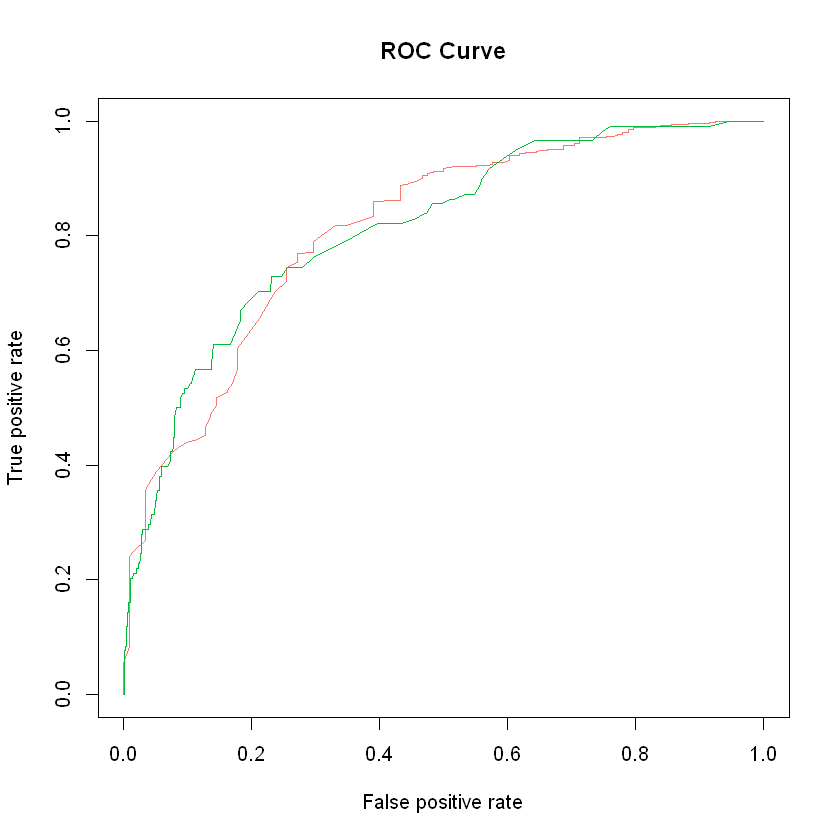

In [549]:
#  import ROCR package for ROC curve plotting - AUC is 81% without resampling
library(ROCR)

# Calculate the probability of new observations belonging to each class
prediction_log_roc_curve <- log_df

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_log_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.log.valid <- performance(pred, measure = "auc")
 print(auc.log.valid@y.values)
 }

In [550]:
# calculate accuracy on validation set -  89.9% accuracy without oversampling
log_acc_valid <- accuracy(valid_processed$subscribe, log.pred2)
log_acc_valid

[1] 0.8990476

[1] 0.2033898

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.1.2 Logistic Regression -  RESAMPLING WITH SMOTE 

In [552]:
# resample the data in the train set using SMOTE - makes the classes more balanced 
# undersamples majority class (0) and oversamples minority class (1)
set.seed(1)
up_train <- SMOTE(subscribe ~ ., data  = train_processed[, -51])                         
table(up_train$subscribe) 


   0    1 
2284 1713 

In [553]:
# convert target variable to factor in order for the model to work correctly
up_train$subscribe <- as.factor(up_train$subscribe)

# train the logistic regression model on resampled train data
log.up = glm(subscribe ~ ., family=binomial(link="logit"),data=up_train[, -1])
summary(log.up)


Call:
glm(formula = subscribe ~ ., family = binomial(link = "logit"), 
    data = up_train[, -1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0875  -0.8061  -0.5920   0.8347   1.9135  

Coefficients: (21 not defined because of singularities)
                                     Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        -1.535e+02  2.738e+02  -0.561   0.5750  
pdays                              -8.219e-02  5.764e-02  -1.426   0.1539  
emp_var_rate                        4.802e+00  2.498e+00   1.922   0.0546 .
euribor3m                           1.725e+00  9.523e-01   1.811   0.0701 .
nr_employed                         3.458e-02  5.772e-02   0.599   0.5492  
pdays_999                           7.959e+01  5.717e+01   1.392   0.1639  
nremply_ge_mean                    -3.653e+01  2.846e+01  -1.283   0.1994  
pdays_ge_mean                              NA         NA      NA       NA  
emp_varrate_positive                1.543e+01 

In [554]:
#test on validation set
log.pred.up = plogis(predict(log.up, newdata = valid_processed[, -1]))

# if probabibility is > 0.5 consider as subscribe
log.pred.up2 <- ifelse(log.pred.up > 0.5,1,0)

# look at the confusion matrix
table(observed=valid_processed$subscribe,predicted=log.pred.up2)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

        predicted
observed   0   1
       0 801 131
       1  47  71

In [555]:
# convert output to a form that has 2 columns - probability for 0 and 1
log_df_up <- data.frame(log.pred.up)
log_df_up$one <- log_df_up$log.pred.up
log_df_up$zero <- 1 - log_df_up$log.pred.up
log_df_up <- log_df_up[-1]
log_df_up[, '0'] <- log_df_up[, 'zero'] 
log_df_up[, '1'] <- log_df_up[, 1]
log_df_up <- log_df_up[-1]
log_df_up <- log_df_up[-1]
head(log_df_up)

0,1
0.7093839,0.2906161
0.8309753,0.1690247
0.6826308,0.3173692
0.8392439,0.1607561
0.6243371,0.3756629
0.7097393,0.2902607


[[1]]
[1] 0.8082582

[[1]]
[1] 0.8082582



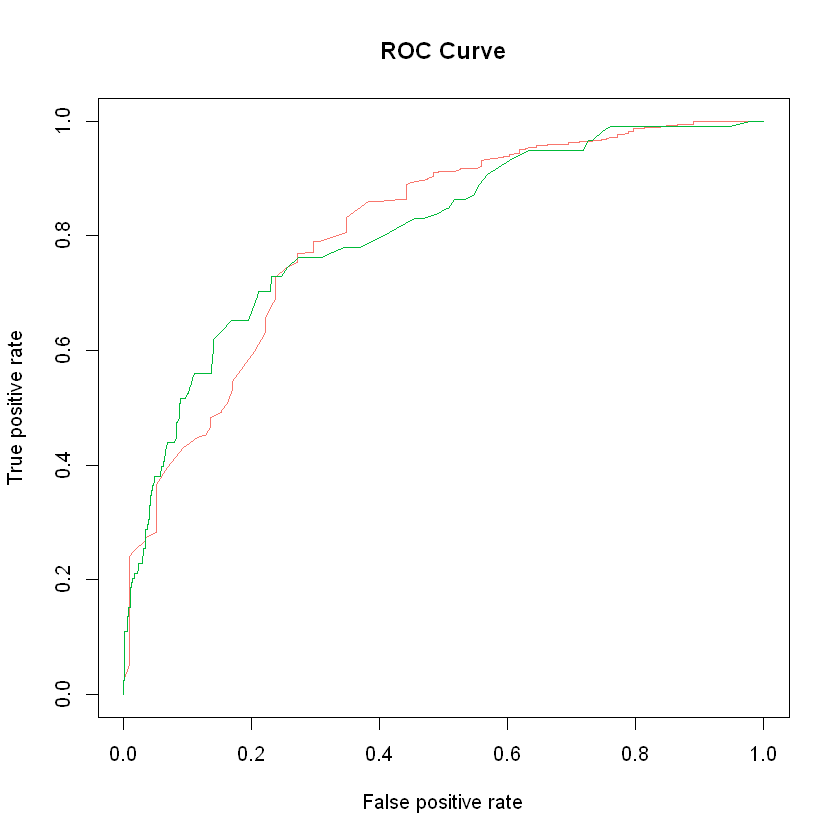

In [556]:
#  import ROCR package for ROC curve plotting - AUC is 80.8% with resampling, slight drop from the initial model (81%)
library(ROCR)

# Calculate the probability of new observations belonging to each class
prediction_log_up_roc_curve <- log_df_up

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_log_up_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.log.valid.up <- performance(pred, measure = "auc")
 print(auc.log.valid.up@y.values)
 }

In [557]:
# calculate accuarcay on validation set - 83% with resampling - accuracy decreases from model without resampling
log_acc_valid_up <- accuracy(valid_processed$subscribe, log.pred.up2)
log_acc_valid_up

[1] 0.8304762

[1] 0.6016949

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.2.1 Decision Tree Model - WITHOUT RESAMPLING

In [559]:
require(tree)
# Fit the classification tree
classtree <- tree(subscribe ~ ., data=train_processed[, -1])
summary(classtree)

Loading required package: tree
Warning message:
"package 'tree' was built under R version 3.6.2"


Classification tree:
tree(formula = subscribe ~ ., data = train_processed[, -1])
Variables actually used in tree construction:
[1] "nr_employed"      "pdays"            "woe_month_binned"
Number of terminal nodes:  4 
Residual mean deviance:  0.5868 = 2873 / 4896 
Misclassification error rate: 0.1033 = 506 / 4900 

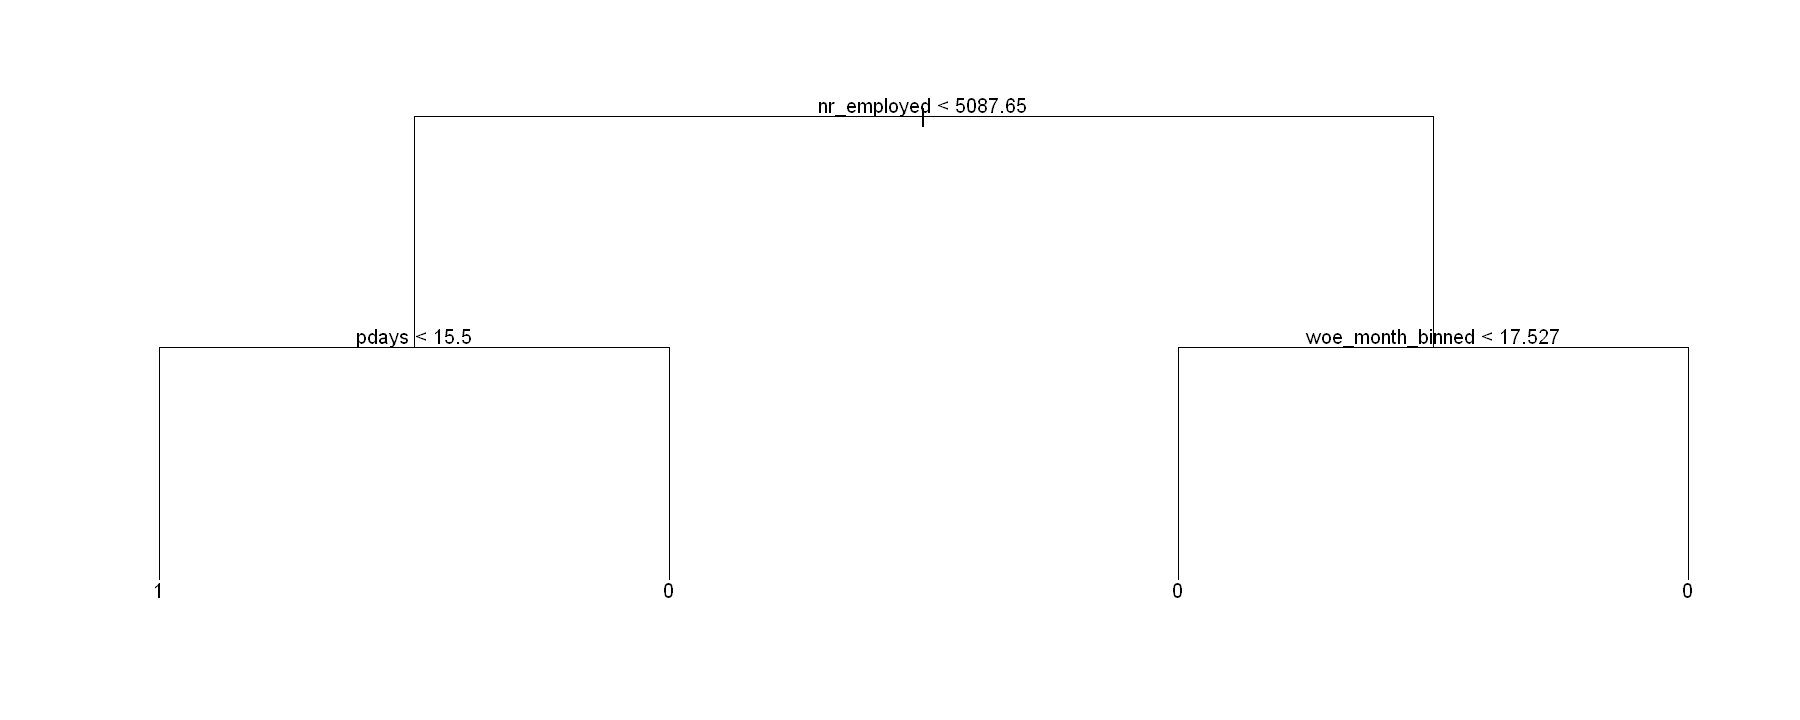

In [560]:
# Plot the classification tree
options(repr.plot.width=15, repr.plot.height=6)
plot(classtree, type='uniform')
text(classtree, pretty=0)

In [561]:
# look at the structure of the tree 
classtree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 4900 3528.0 0 ( 0.88347 0.11653 )  
  2) nr_employed < 5087.65 632  862.7 0 ( 0.57278 0.42722 )  
    4) pdays < 15.5 145  170.8 1 ( 0.27586 0.72414 ) *
    5) pdays > 15.5 487  623.6 0 ( 0.66119 0.33881 ) *
  3) nr_employed > 5087.65 4268 2177.0 0 ( 0.92948 0.07052 )  
    6) woe_month_binned < 17.527 3920 1706.0 0 ( 0.94337 0.05663 ) *
    7) woe_month_binned > 17.527 348  372.8 0 ( 0.77299 0.22701 ) *

In [562]:
# predict on the validation set 
tree_pred_valid <- predict(classtree, newdata=valid_processed[, -1], type='class')
tree_pred_proba_valid <- predict(classtree, newdata=valid_processed[, -1], type='vector')

# look at the confusion matrix
table(tree_pred_valid, valid_processed$subscribe)


               
tree_pred_valid   0   1
              0 924  97
              1   8  21

[[1]]
[1] 0.7465902

[[1]]
[1] 0.7465902



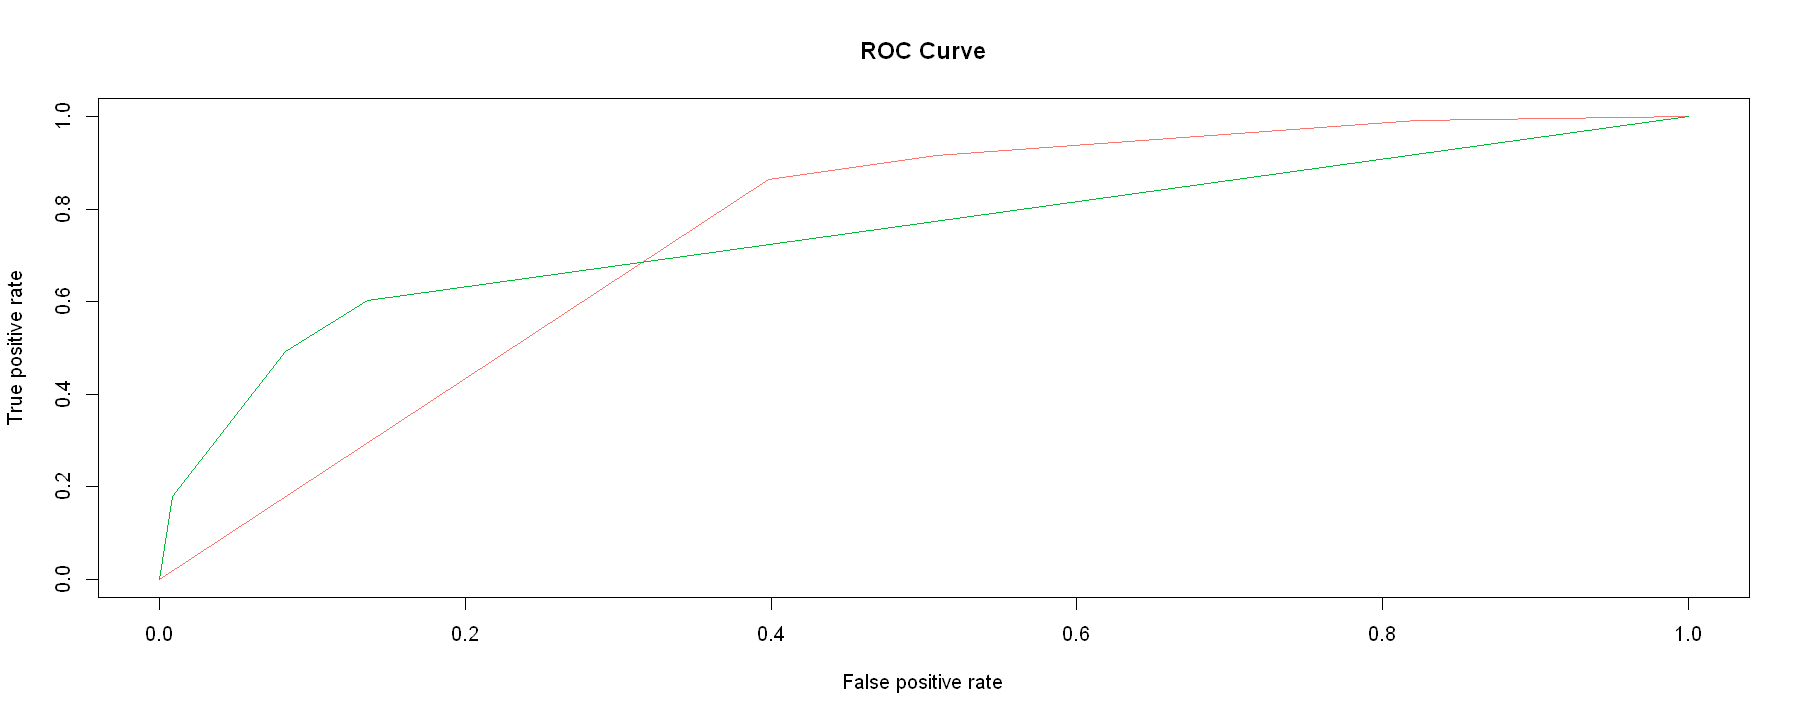

In [563]:
# calculate the AUC - AUC is 74.6% without oversampling
#  import ROCR package for ROC curve plotting:
library(ROCR)

# Calculate the probability of new observations belonging to each class
prediction_tree_roc_curve <- predict(classtree,valid_processed[, -1],type="vector")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(valid_processed$subscribe)


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_tree_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.tree.valid <- performance(pred, measure = "auc")
 print(auc.tree.valid@y.values)
 }

In [564]:
# calculate accuracy metric on validation set - 90% accuracy without oversampling
tree_acc_valid <- accuracy(valid_processed$subscribe, tree_pred_valid)
tree_acc_valid

[1] 0.9

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.2.2. Decision Tree - WITH OVERSAMPLING

In [566]:
# resample the data in the train set using SMOTE - makes the classes more balanced 
# undersamples majority class (0) and oversamples minority class (1)
set.seed(1)
up_train <- SMOTE(subscribe ~ ., data  = train_processed[, -51])                         
table(up_train$subscribe) 


   0    1 
2284 1713 

In [567]:
# convert target variable to factor for the model to run without error 
up_train$subscribe <- as.factor(up_train$subscribe)

classtree.up <- tree(subscribe ~ ., data=up_train[, -1])
summary(classtree.up) 
# with resampling the misclassification error rate goes up from 10% to 23%


Classification tree:
tree(formula = subscribe ~ ., data = up_train[, -1])
Variables actually used in tree construction:
[1] "nr_employed"                  "pdays"                       
[3] "woe_month_binned"             "euribor3m_freq_bin_incidence"
[5] "euribor3m_freq_bin_woe"      
Number of terminal nodes:  6 
Residual mean deviance:  1.039 = 4145 / 3991 
Misclassification error rate: 0.2337 = 934 / 3997 

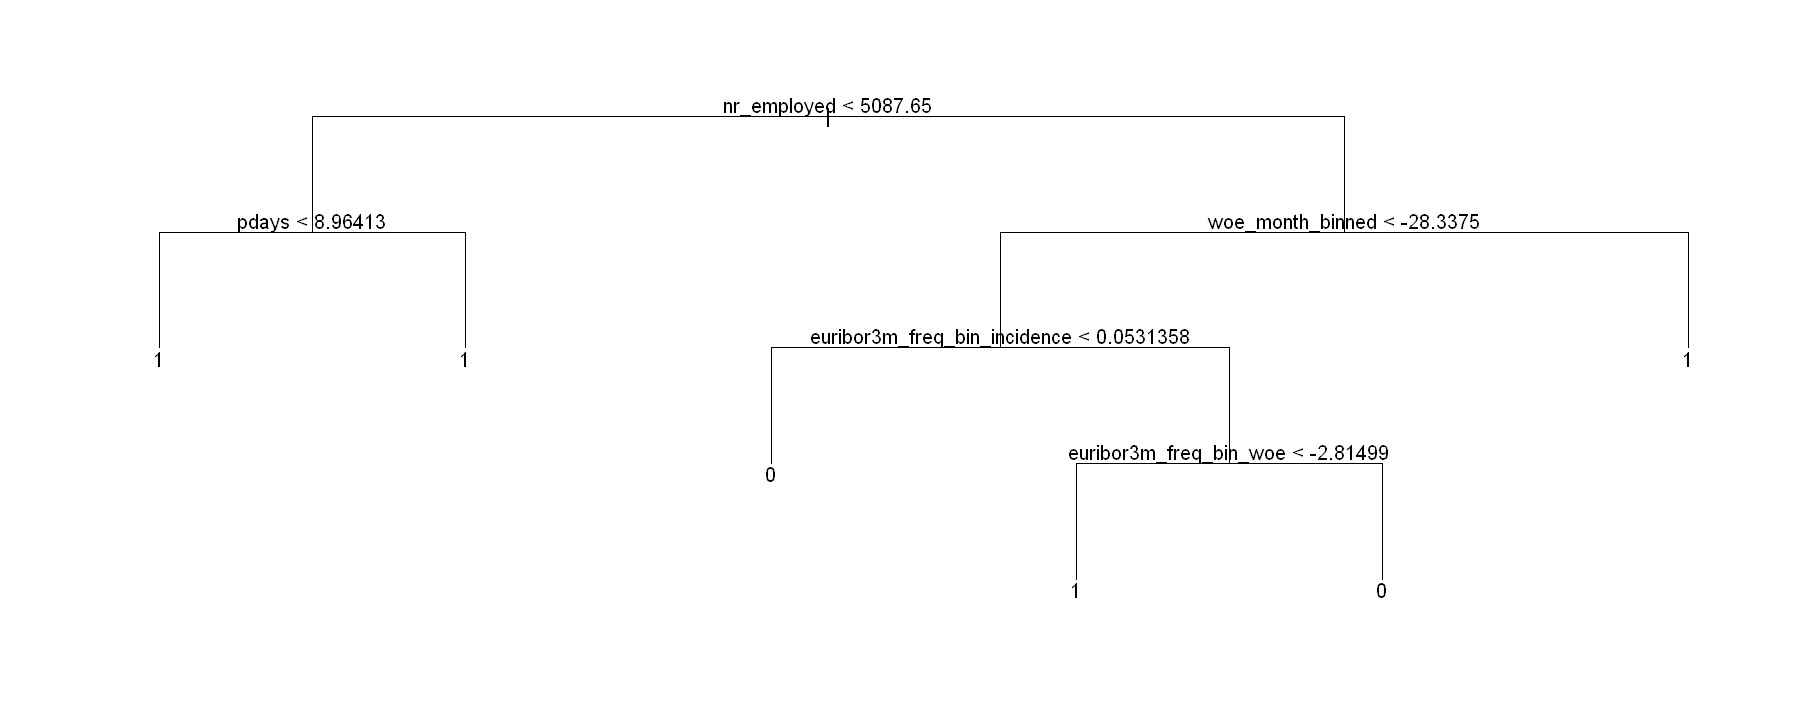

In [568]:
# Plot the classification tree
options(repr.plot.width=15, repr.plot.height=6)
plot(classtree.up, type='uniform')
text(classtree.up, pretty=0)

In [569]:
# look at the structure of the tree
classtree.up

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 3997 5459.00 0 ( 0.57143 0.42857 )  
   2) nr_employed < 5087.65 997  962.40 1 ( 0.18756 0.81244 )  
     4) pdays < 8.96413 289   80.16 1 ( 0.03114 0.96886 ) *
     5) pdays > 8.96413 708  798.50 1 ( 0.25141 0.74859 ) *
   3) nr_employed > 5087.65 3000 3670.00 0 ( 0.69900 0.30100 )  
     6) woe_month_binned < -28.3375 2628 2975.00 0 ( 0.74658 0.25342 )  
      12) euribor3m_freq_bin_incidence < 0.0531358 1156 1077.00 0 ( 0.82353 0.17647 ) *
      13) euribor3m_freq_bin_incidence > 0.0531358 1472 1832.00 0 ( 0.68614 0.31386 )  
        26) euribor3m_freq_bin_woe < -2.81499 54    0.00 1 ( 0.00000 1.00000 ) *
        27) euribor3m_freq_bin_woe > -2.81499 1418 1702.00 0 ( 0.71227 0.28773 ) *
     7) woe_month_binned > -28.3375 372  487.40 1 ( 0.36290 0.63710 ) *

In [570]:
# predict on the validation set 

tree_pred_valid_up <- predict(classtree.up, newdata=valid_processed[, -1], type='class')
tree_pred_proba_valid_up <- predict(classtree.up, newdata=valid_processed[, -1], type='vector')

# look at the confusion matrix
table(tree_pred_valid_up, valid_processed$subscribe)


                  
tree_pred_valid_up   0   1
                 0 805  47
                 1 127  71

[[1]]
[1] 0.7781107

[[1]]
[1] 0.7781107



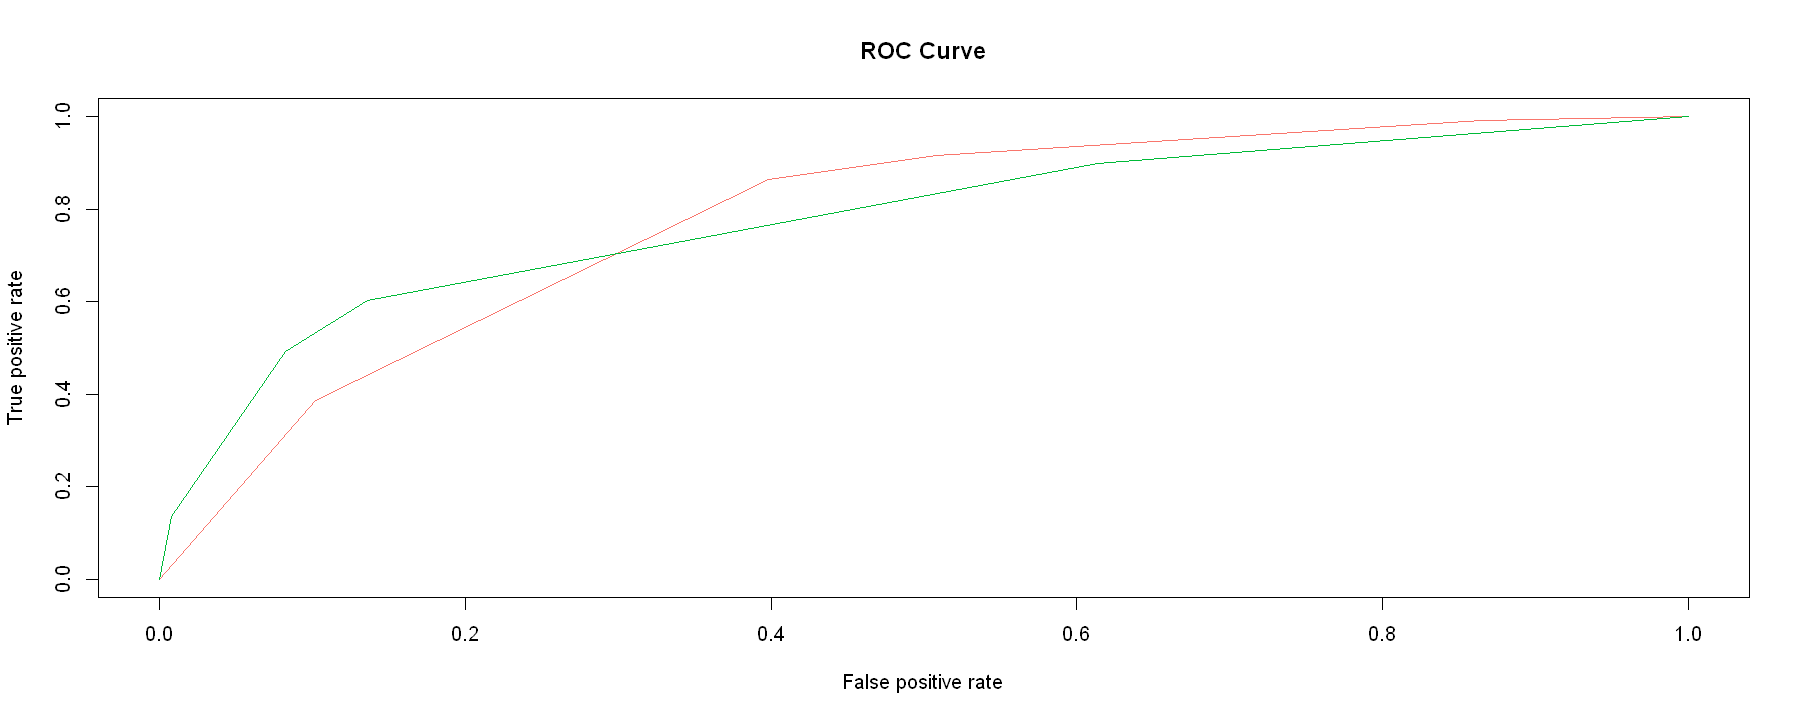

In [571]:
# calculate the AUC - AUC with resmpling is 77.8%, improvement from 74.6% AUC without resampling

# Calculate the probability of new observations belonging to each class
prediction_tree_up_roc_curve <- predict(classtree.up,valid_processed[, -1],type="vector")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(valid_processed$subscribe)


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_tree_up_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.tree.up.valid <- performance(pred, measure = "auc")
 print(auc.tree.up.valid@y.values)
 }

In [572]:
# calculate accuracy metric on validation set - accuracy is 83.4% with oversampling, decrease from first model (90%)
tree_acc_valid_up <- accuracy(valid_processed$subscribe, tree_pred_valid_up)
tree_acc_valid_up

[1] 0.8342857

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.3.1. Random Forest Model - WITHOUT RESAMPLING

In [574]:
# find best hyperparameters 
#modellist <- list()
#for (ntrees in c(1000, 1500, 2000, 2500)) {
#    for (mtrys in c(2, 6, 10, 14)) {
#        fit <- randomForest(subscribe ~ ., data=train_processed[, -1], ntree=ntrees, mtry=mtrys, importance = TRUE) 
#        key <- toString(ntrees + mtrys)
#        modellist[[key]] <- fit
#}
#}
## compare results
#results <- modellist

In [575]:
# train the model on the train set - tried different combinations for ntree and mtry and checked improvement on validation set
# the parameters selected here gave the best results from the combinations tried 
# ntrees tried 800, 1000, 1500, 2000, 2500
# mtry tried 2, 6, 8, 10, 14
rdf =  randomForest(subscribe ~ ., data=train_processed[, -1], ntree=2500,mtry=14, importance = TRUE) 
rdf


Call:
 randomForest(formula = subscribe ~ ., data = train_processed[,      -1], ntree = 2500, mtry = 14, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 2500
No. of variables tried at each split: 14

        OOB estimate of  error rate: 10.45%
Confusion matrix:
     0   1 class.error
0 4257  72  0.01663202
1  440 131  0.77057793

In [576]:
# test model on validation set 
rdf.pred = predict(rdf, newdata = valid_processed[, -1], type='response')
table(observed=valid_processed$subscribe,predicted=rdf.pred)

        predicted
observed   0   1
       0 912  20
       1  94  24

In [577]:
# error of 11%
(94+20)/(912+20+94+24)

[1] 0.1085714

[[1]]
[1] 0.7575244

[[1]]
[1] 0.7575244



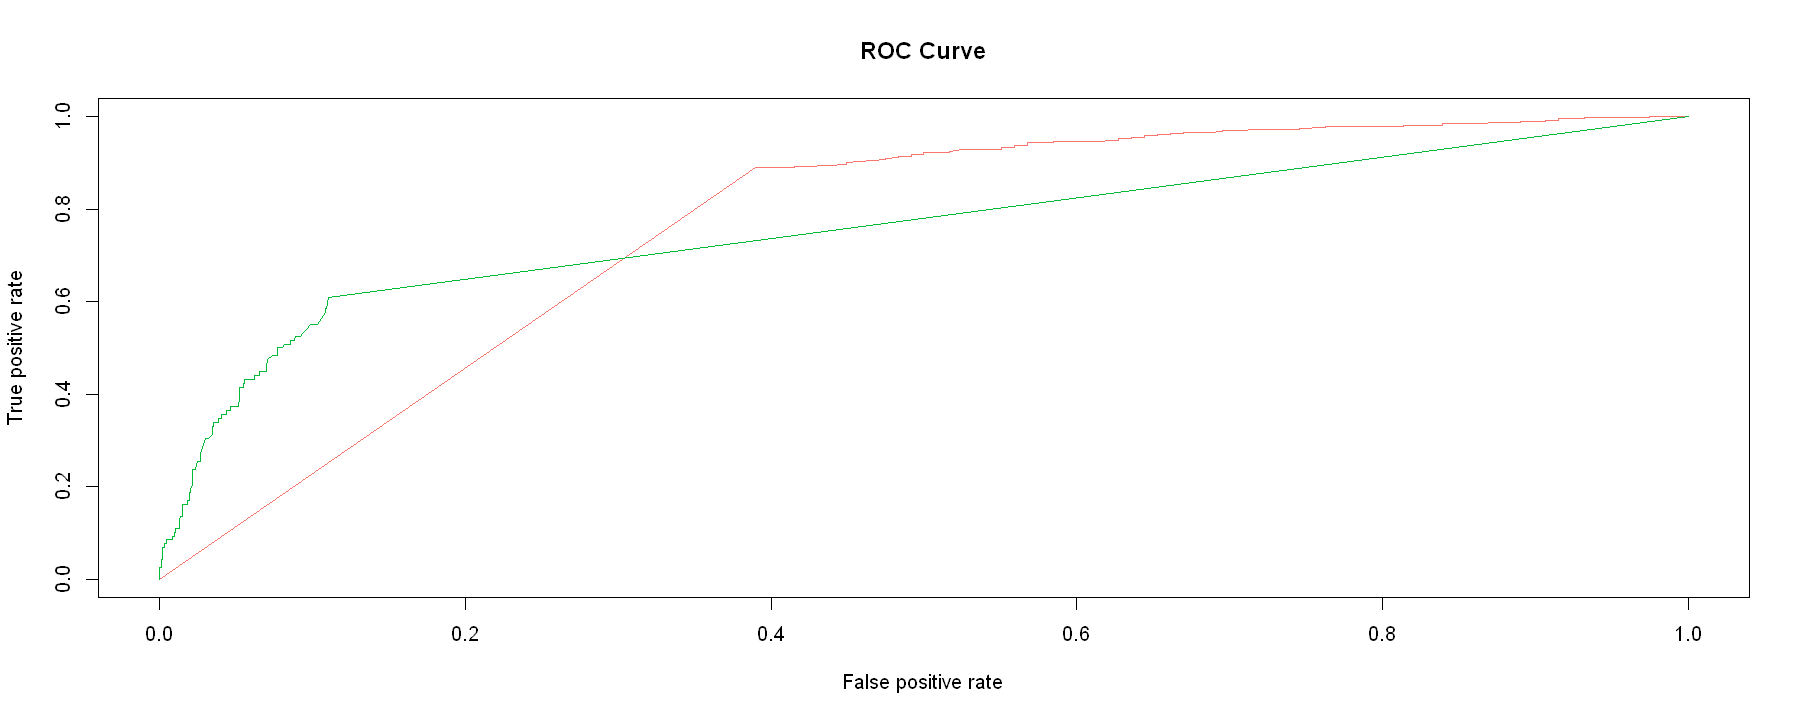

In [578]:
# calculate AUC - 75.7% AUC on validation set without resampling

#  import ROCR package for ROC curve plotting:
library(ROCR)
# Calculate the probability of new observations belonging to each class

prediction_rf_roc_curve <- predict(rdf,valid_processed[, -1],type="prob")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(valid_processed$subscribe)


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_rf_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.rf.valid <- performance(pred, measure = "auc")
 print(auc.rf.valid@y.values)
 }

In [579]:
# calculate accuracy metrics on validation set - 89.1% accuracy without oversampling
rf_acc_valid <- accuracy(valid_processed$subscribe, rdf.pred)
rf_acc_valid


[1] 0.8914286

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.3.2. Random Forest Model - WITH RESAMPLING

In [581]:
# resample the data in the train set using SMOTE - makes the classes more balanced 
# undersamples majority class (0) and oversamples minority class (1)
set.seed(1)
up_train <- SMOTE(subscribe ~ ., data  = train_processed[, -1])                         
table(up_train$subscribe) 

Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'DMwR' is in use and will not be installed"


   0    1 
2284 1713 

In [582]:
# convert target variable to factor for the model to run without error 
up_train$subscribe <- as.factor(up_train$subscribe)

# train model on train set - use same parameters as last model
rdf_up =  randomForest(subscribe ~ ., data=up_train[, -1], ntree=2500,mtry=14, importance = TRUE) 

rdf_up # class error for class 1 has reduced from 76% to 36%


Call:
 randomForest(formula = subscribe ~ ., data = up_train[, -1],      ntree = 2500, mtry = 14, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 2500
No. of variables tried at each split: 14

        OOB estimate of  error rate: 24.34%
Confusion matrix:
     0    1 class.error
0 1963  321   0.1405429
1  652 1061   0.3806188

In [583]:
# test model on the validation set
rdf.pred.up = predict(rdf_up, newdata = valid_processed[, -1], type='response')

# look at confusion matrix
table(observed=valid_processed$subscribe,predicted=rdf.pred.up)

        predicted
observed   0   1
       0 804 128
       1  50  68

In [584]:
# error rate of 16% with resampling - goes up from  earlier 11% 
(50+128)/(50+128+804+68)

[1] 0.1542857

[[1]]
[1] 0.7895859

[[1]]
[1] 0.7895859



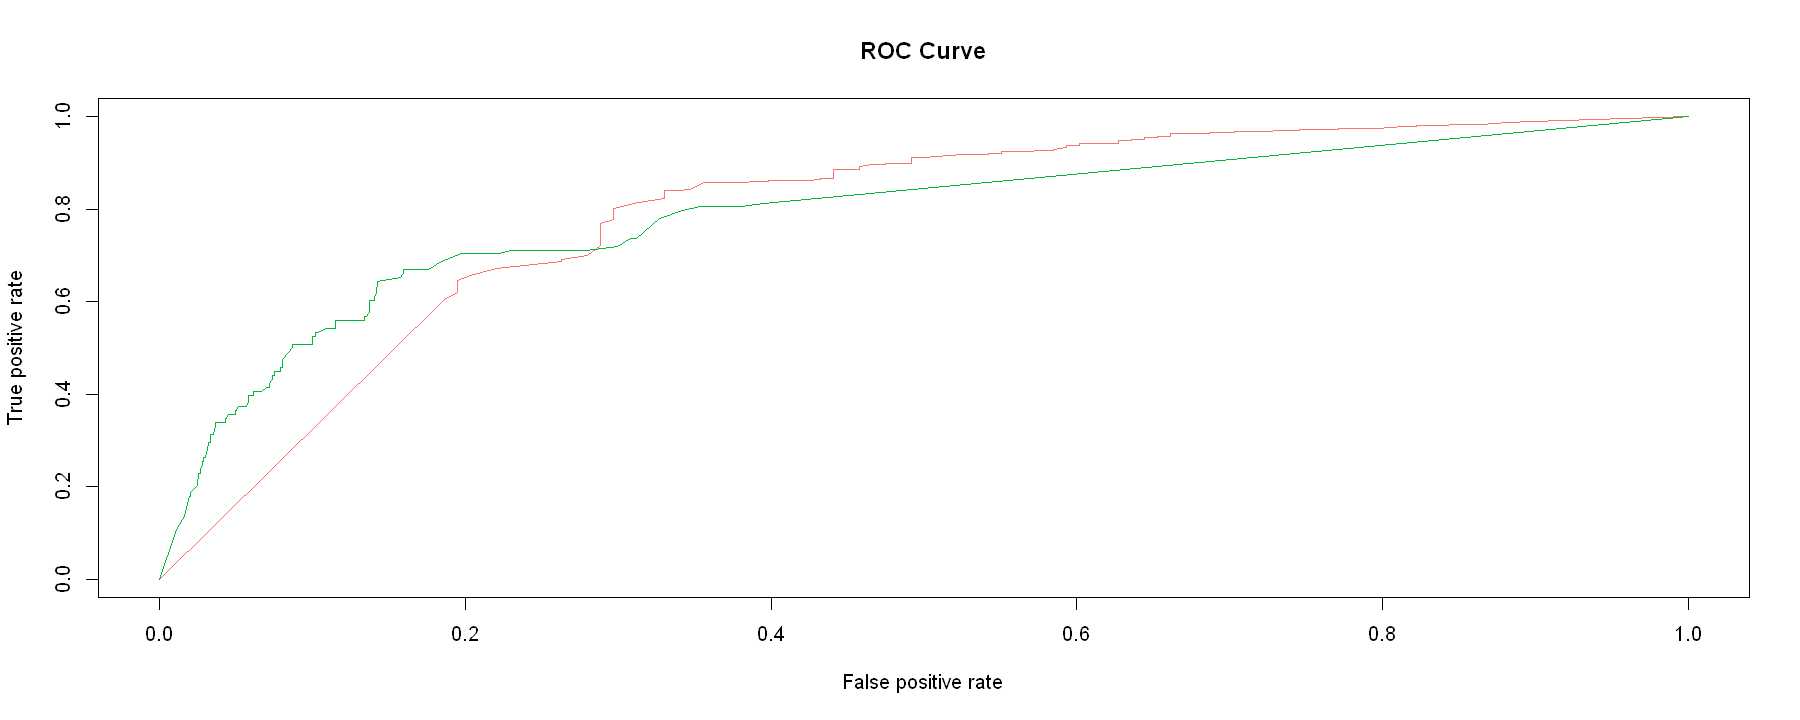

In [585]:
# calculate AUC - 78.9% AUC on validation set with resampling, improvement from earlier 75.7%


#  import ROCR package for ROC curve plotting:
library(ROCR)
# Calculate the probability of new observations belonging to each class

prediction_rfup_roc_curve <- predict(rdf_up,valid_processed[, -1],type="prob")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(valid_processed$subscribe)


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_rfup_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.rf.valid.up <- performance(pred, measure = "auc")
 print(auc.rf.valid.up@y.values)
 }

In [586]:
# calculate accuracy metric on validation set - 83% accuracy with oversampling

rf_acc_valid_up <- accuracy(valid_processed$subscribe, rdf.pred.up)
rf_acc_valid_up


[1] 0.8304762

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.4.1. Gradient Boosting Model - WITHOUT RESAMPLING

In [588]:
# had to convert target variable to character for the model to run without an error 
train_processed$subscribe <- as.character(train_processed$subscribe)

# train gradient boosting model on train set. 
# Different combinations of parameters tried - ones with best results on validation set used 
# tried n.trees 500, 1000, 1500, 2000
# tried shrinkage 0.001, 0.01, 0.05, 0.1
# treid interaction depth 4, 6
gb =gbm(subscribe ~ . , data = train_processed[, -1],distribution = "bernoulli", n.trees = 1500,
                  shrinkage = 0.01, interaction.depth = 4)
gb

gbm(formula = subscribe ~ ., distribution = "bernoulli", data = train_processed[, 
    -1], n.trees = 1500, interaction.depth = 4, shrinkage = 0.01)
A gradient boosted model with bernoulli loss function.
1500 iterations were performed.
There were 50 predictors of which 25 had non-zero influence.

In [589]:
# test model on validation set 
gb.pred = predict(gb ,valid_processed[, -1], n.trees = 1500, type='response')

# if probabibility is > 0.5 consider as subscribe
gb.pred2 <- ifelse(gb.pred > 0.5,1,0)

[1] 0.05905005 0.05386879 0.07215758 0.03923108 0.09296949 0.06115408
   [7] 0.28683842 0.08809176 0.07013402 0.06579397 0.04702889 0.04909630
  [13] 0.04677941 0.04909630 0.07657585 0.04909630 0.04970697 0.05024341
  [19] 0.11485641 0.10641401 0.05670283 0.05024341 0.05386879 0.09296949
  [25] 0.30993658 0.09621064 0.12378720 0.05467904 0.05132529 0.04341502
  [31] 0.31978980 0.04752285 0.06951601 0.24269355 0.03944029 0.15664060
  [37] 0.06433660 0.03923108 0.07215758 0.06115408 0.04902145 0.04700756
  [43] 0.05054226 0.06538105 0.05524927 0.05386879 0.03966503 0.05024341
  [49] 0.04902145 0.04909630 0.05386879 0.07053764 0.08809176 0.04702889
  [55] 0.04600360 0.04700756 0.31896561 0.06538105 0.69268249 0.03923108
  [61] 0.03966503 0.30162335 0.03923108 0.05386879 0.05024341 0.06115408
  [67] 0.06115408 0.07215758 0.04600360 0.06538105 0.06115408 0.24269355
  [73] 0.06579397 0.04702889 0.03944029 0.03923108 0.03935364 0.05603980
  [79] 0.03923108 0.05517084 0.04642709 0.06115408 0.04600360 0.64790409
  [85] 0.26079290 0.04028956 0.07013402 0.06115408 0.04341502 0.15664060
  [91] 0.03963665 0.07657585 0.25161758 0.04970697 0.10641401 0.03923108
  [97] 0.05603980 0.06115408 0.06538105 0.04702889 0.03923108 0.04028956
 [103] 0.05905005 0.04702889 0.03923108 0.06115408 0.34785932 0.04902145
 [109] 0.11485641 0.03923108 0.06115408 0.07657585 0.25871284 0.05386879
 [115] 0.05386879 0.73447716 0.36003708 0.05603980 0.06538105 0.27981062
 [121] 0.27002865 0.04700756 0.27002865 0.09296949 0.04700756 0.04902145
 [127] 0.03935364 0.06433660 0.04028956 0.18923276 0.03935364 0.08809176
 [133] 0.05603980 0.04702889 0.03923108 0.03923108 0.09296949 0.16560155
 [139] 0.06115408 0.03935364 0.05524927 0.09621064 0.51979672 0.07053764
 [145] 0.05054226 0.05524927 0.04970697 0.04702889 0.07013402 0.08809176
 [151] 0.03935364 0.08352037 0.54418897 0.58880659 0.09621064 0.07053764
 [157] 0.07013402 0.09296949 0.09447248 0.06115408 0.11485641 0.44302036
 [163] 0.09296949 0.03923108 0.07053764 0.06115408 0.04909630 0.05054226
 [169] 0.04028956 0.06579397 0.06115408 0.03944029 0.33269731 0.04370055
 [175] 0.05517084 0.05524927 0.04702889 0.05442730 0.65611351 0.39570157
 [181] 0.03963665 0.11485641 0.05024341 0.07657585 0.23684619 0.06951601
 [187] 0.08352037 0.03935364 0.07215758 0.06579397 0.06115408 0.06579397
 [193] 0.03963665 0.05524927 0.19816856 0.04677941 0.07053764 0.05603980
 [199] 0.11485641 0.27002865 0.04909630 0.06579397 0.06538105 0.04677941
 [205] 0.05524927 0.05054226 0.06951601 0.03923108 0.03923108 0.04341502
 [211] 0.05467904 0.06115408 0.04902145 0.06951601 0.09621064 0.03923108
 [217] 0.07013402 0.04600360 0.11485641 0.06115408 0.07013402 0.11041364
 [223] 0.05524927 0.05054226 0.06579397 0.09296949 0.06579397 0.05524927
 [229] 0.03944029 0.05517084 0.23532939 0.18923276 0.10641401 0.08809176
 [235] 0.05426378 0.09296949 0.05467904 0.81277070 0.42674838 0.07215758
 [241] 0.03963665 0.54417557 0.07013402 0.04700756 0.15664060 0.08352037
 [247] 0.33755173 0.06115408 0.06538105 0.05054226 0.03923108 0.04970697
 [253] 0.06433660 0.04677941 0.31538555 0.10641401 0.03963665 0.03923108
 [259] 0.09621064 0.03966503 0.04909630 0.04702889 0.05024341 0.07013402
 [265] 0.18923276 0.03944029 0.03935364 0.04909630 0.10641401 0.05524927
 [271] 0.03935364 0.21666774 0.05132529 0.05905005 0.03963665 0.24269355
 [277] 0.05517084 0.39570157 0.06115408 0.21141354 0.07013402 0.05024341
 [283] 0.41243168 0.05524927 0.06579397 0.03923108 0.04677941 0.05054226
 [289] 0.70148402 0.04902145 0.27403265 0.05524927 0.11485641 0.06538105
 [295] 0.76790234 0.09621064 0.03923108 0.09621064 0.66173937 0.04902145
 [301] 0.28680816 0.09621064 0.03923108 0.05132529 0.20989520 0.05054226
 [307] 0.27403265 0.05024341 0.04378033 0.06579397 0.07657585 0.66703051
 [313] 0.37529996 0.56705678 0.80302335 0.04702889 0.05524927 0.05386879
 [319] 0.08352037 0.04600360 0.05905005 0.05905005 0.03935364 0.04600360
 [325] 0.03944029 0.06115408 0.05603980 0.09296949 0.04902145

In [590]:
# look at the confusion matrix - 89.3% accuracy
cm = confusionMatrix(as.factor(valid_processed$subscribe), as.factor(gb.pred2))
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 912  20
         1  92  26
                                          
               Accuracy : 0.8933          
                 95% CI : (0.8731, 0.9114)
    No Information Rate : 0.9562          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2711          
                                          
 Mcnemar's Test P-Value : 1.961e-11       
                                          
            Sensitivity : 0.9084          
            Specificity : 0.5652          
         Pos Pred Value : 0.9785          
         Neg Pred Value : 0.2203          
             Prevalence : 0.9562          
         Detection Rate : 0.8686          
   Detection Prevalence : 0.8876          
      Balanced Accuracy : 0.7368          
                                          
       'Positive' Class : 0               
                              

In [591]:
# convert output to a form that has 2 columns - probability for 0 and 1
gb_df <- data.frame(gb.pred)
gb_df$one <- gb_df$gb.pred
gb_df$zero <- 1 - gb_df$gb.pred
gb_df <- gb_df[-1]
gb_df[, '0'] <- gb_df[, 'zero'] 
gb_df[, '1'] <- gb_df[, 1]
gb_df <- gb_df[-1]
gb_df <- gb_df[-1]

0,1
0.9409499,0.05905005
0.9461312,0.05386879
0.9278424,0.07215758
0.9607689,0.03923108
0.9070305,0.09296949
0.9388459,0.06115408
0.7131616,0.28683842
0.9119082,0.08809176
0.9298660,0.07013402
0.9342060,0.06579397


[[1]]
[1] 0.8013839

[[1]]
[1] 0.8013839



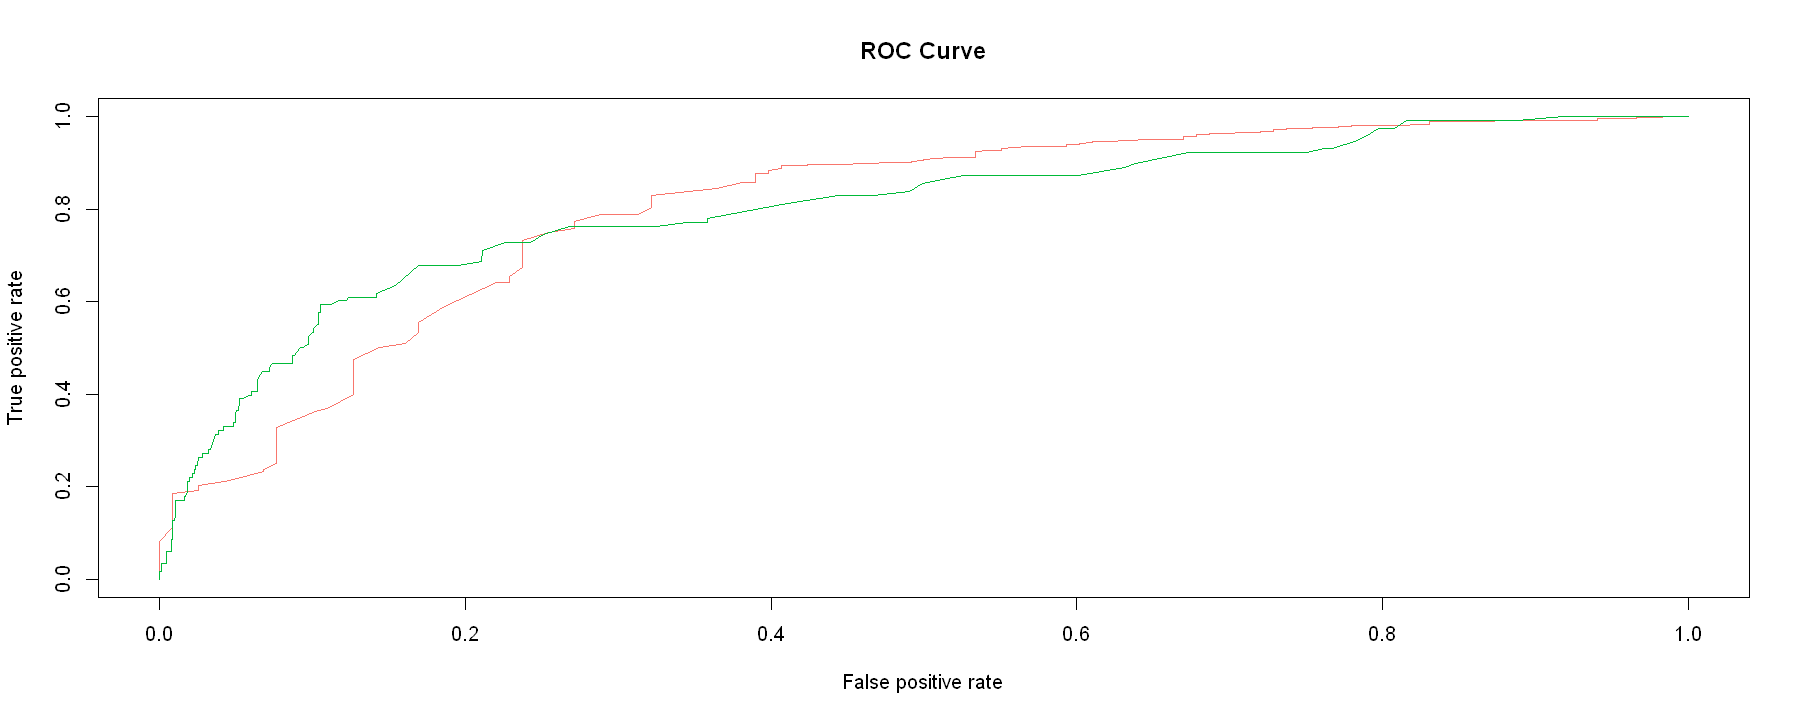

In [592]:
#  import ROCR package for ROC curve plotting - AUC is 80.1% without resampling
library(ROCR)

# Calculate the probability of new observations belonging to each class
prediction_gb_roc_curve <- gb_df

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_gb_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.gb.valid <- performance(pred, measure = "auc")
 print(auc.gb.valid@y.values)
 }

In [593]:
# calculate accuracy metric on validation set - 89.3% accuracy without resampling
gb_acc_valid <- accuracy(valid_processed$subscribe, gb.pred2)
gb_acc_valid

[1] 0.8933333

[1] 0.220339

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.4.2. Gradient Boosting Model -  WITH RESAMPLING

In [595]:
# resample the data in the train set using SMOTE - makes the classes more balanced 
# undersamples majority class (0) and oversamples minority class (1)

set.seed(1)
train_processed$subscribe <- as.factor(train_processed$subscribe)
up_train <- SMOTE(subscribe ~ ., data  = train_processed[, -1])                         
table(up_train$subscribe) 

# need to convert the target variable to character for the model to run without giving en error
up_train$subscribe <- as.character(up_train$subscribe)

Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'DMwR' is in use and will not be installed"


   0    1 
2284 1713 

In [596]:
# train model on training set - same parameters as the last model are used 
gb.up = gbm(subscribe ~ . , data = up_train[, -1], distribution = "bernoulli", n.trees = 1000, shrinkage = 0.01, interaction.depth = 4)
gb.up

gbm(formula = subscribe ~ ., distribution = "bernoulli", data = up_train[, 
    -1], n.trees = 1000, interaction.depth = 4, shrinkage = 0.01)
A gradient boosted model with bernoulli loss function.
1000 iterations were performed.
There were 49 predictors of which 25 had non-zero influence.

,var,rel.inf
euribor3m,euribor3m,36.452869285
nr_employed,nr_employed,15.290372449
nr_employed_freq_bin_incidence,nr_employed_freq_bin_incidence,11.761027233
month_binned_nov_aug_jun_jul_may,month_binned_nov_aug_jun_jul_may,7.523606880
pdays_999,pdays_999,6.490335034
nr_employed_binned___Inf_5076_2_,nr_employed_binned___Inf_5076_2_,4.959156697
month_incidence,month_incidence,3.302986355
woe_nr_employed_binned,woe_nr_employed_binned,2.806409601
woe_cons_conf_idx_binned,woe_cons_conf_idx_binned,2.577373624
euribor3m_freq_bin_incidence,euribor3m_freq_bin_incidence,1.961869090


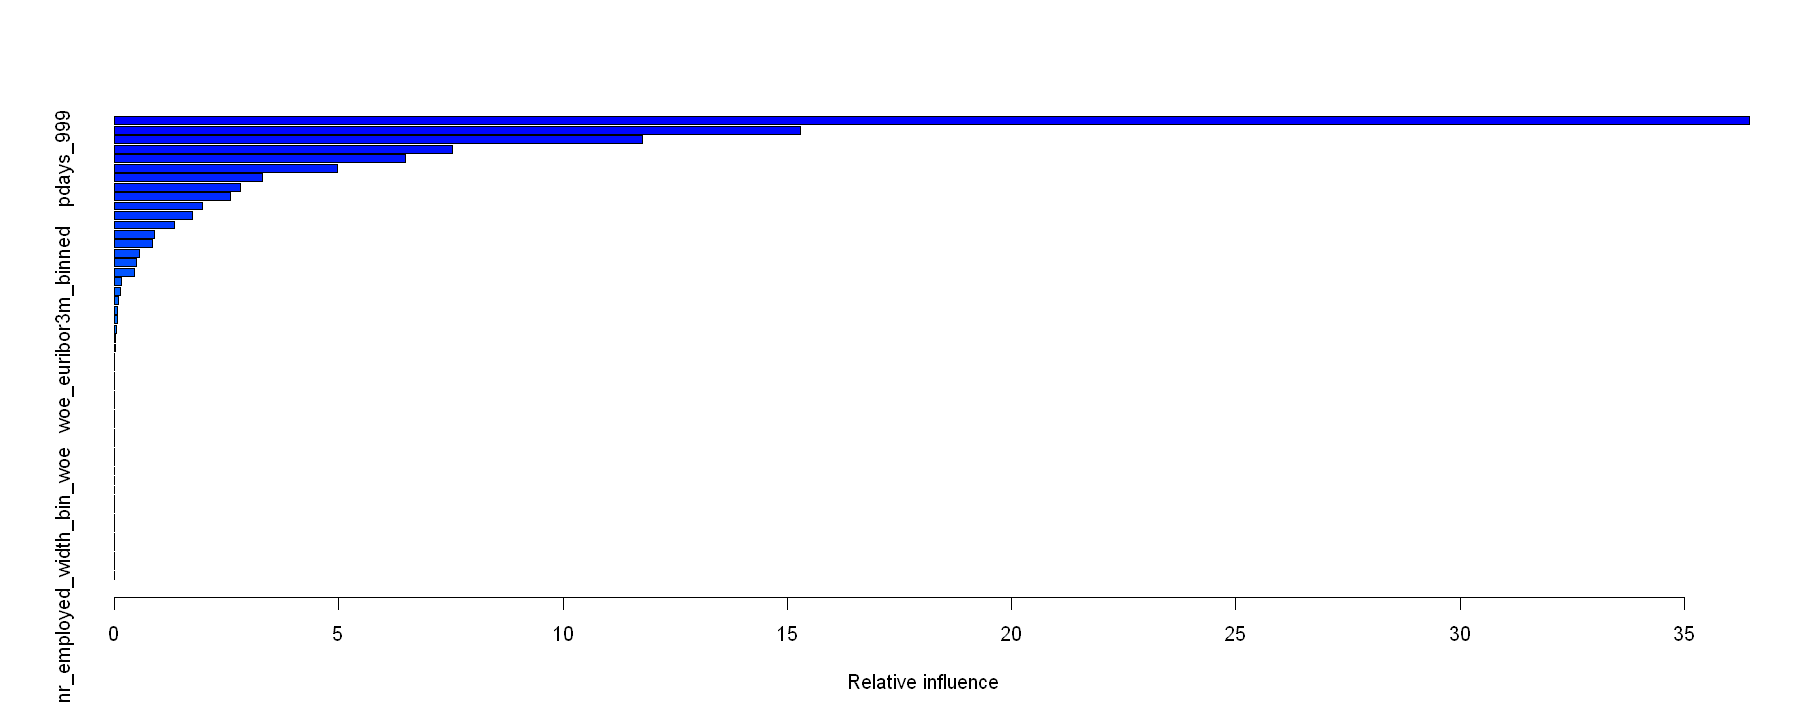

In [597]:
# summary of model
summary(gb.up)

In [598]:
# test model on validation set
gb.pred.up = predict(gb.up ,valid_processed[, -1], n.trees = 1000, type='response')

# if probabibility is > 0.5 consider as subscribe
gb.pred2.up <- ifelse(gb.pred.up > 0.5,1,0)

[1] 0.2879404 0.1864533 0.3590606 0.1404107 0.3683494 0.3035402 0.6297293
   [8] 0.3870831 0.2445594 0.3250314 0.2592677 0.2555418 0.1927164 0.2555418
  [15] 0.3630269 0.2555418 0.2960537 0.2636534 0.4433042 0.4045356 0.2514018
  [22] 0.2636534 0.1864533 0.3683494 0.6854929 0.3604295 0.4131556 0.2674891
  [29] 0.2300151 0.1493118 0.7025640 0.2368417 0.2334781 0.6579735 0.1545794
  [36] 0.4120548 0.2351151 0.1404107 0.3590606 0.3035402 0.1042542 0.2108175
  [43] 0.2123167 0.3278543 0.2709570 0.1864533 0.1572694 0.2636534 0.1042542
  [50] 0.2555418 0.1864533 0.2366013 0.3870831 0.2592677 0.1509204 0.2108175
  [57] 0.7364934 0.3278543 0.9240963 0.1404107 0.1572694 0.6757555 0.1404107
  [64] 0.1864533 0.2636534 0.3035402 0.3035402 0.3590606 0.1509204 0.3278543
  [71] 0.3035402 0.6579735 0.3250314 0.2403533 0.1545794 0.1404107 0.1365053
  [78] 0.2503909 0.1404107 0.2580832 0.2033309 0.3035402 0.1509204 0.9132901
  [85] 0.6995927 0.2601498 0.2445594 0.3035402 0.1493118 0.4120548 0.1843866
  [92] 0.3630269 0.8113310 0.2960537 0.4045356 0.1404107 0.2497731 0.3035402
  [99] 0.3278543 0.2592677 0.1404107 0.2601498 0.2879404 0.2592677 0.1404107
 [106] 0.3035402 0.7092686 0.1042542 0.4433042 0.1404107 0.3035402 0.3630269
 [113] 0.7797232 0.1864533 0.1864533 0.9604981 0.7532461 0.2503909 0.3278543
 [120] 0.7143571 0.7159502 0.2108175 0.7150089 0.3683494 0.2108175 0.1042542
 [127] 0.1365053 0.2351151 0.2601498 0.6065572 0.1365053 0.3870831 0.2503909
 [134] 0.2592677 0.1404107 0.1404107 0.3683494 0.4169435 0.3035402 0.1365053
 [141] 0.2709570 0.3604295 0.8459761 0.2366013 0.2123167 0.2709570 0.2960537
 [148] 0.2592677 0.2445594 0.3870831 0.1365053 0.2805772 0.7825695 0.9408536
 [155] 0.3604295 0.2366013 0.2445594 0.3683494 0.3671186 0.3035402 0.4433042
 [162] 0.8143149 0.3683494 0.1404107 0.2366013 0.3035402 0.2555418 0.2123167
 [169] 0.2601498 0.3250314 0.3035402 0.1545794 0.6932674 0.1958646 0.2580832
 [176] 0.2709570 0.2592677 0.1794644 0.9314600 0.7811775 0.1843866 0.4433042
 [183] 0.2636534 0.3630269 0.7046529 0.2334781 0.2805772 0.1365053 0.3590606
 [190] 0.3250314 0.3035402 0.3250314 0.1843866 0.2709570 0.6141107 0.1927164
 [197] 0.2366013 0.2503909 0.4433042 0.7150089 0.2555418 0.3250314 0.3278543
 [204] 0.1927164 0.2709570 0.2123167 0.2334781 0.1404107 0.1404107 0.1493118
 [211] 0.2674891 0.3035402 0.1042542 0.2334781 0.3604295 0.1404107 0.2445594
 [218] 0.1509204 0.4433042 0.3035402 0.2445594 0.4212389 0.2709570 0.2123167
 [225] 0.3250314 0.3683494 0.3250314 0.2709570 0.1545794 0.2580832 0.5520911
 [232] 0.6065572 0.4045356 0.3870831 0.2027499 0.3683494 0.2674891 0.9168347
 [239] 0.8030252 0.3590606 0.1843866 0.9209235 0.2445594 0.2108175 0.4120548
 [246] 0.2805772 0.7776024 0.3035402 0.3278543 0.2123167 0.1404107 0.2960537
 [253] 0.2351151 0.1927164 0.7299787 0.4045356 0.1843866 0.1404107 0.3604295
 [260] 0.1572694 0.2555418 0.2592677 0.2636534 0.2445594 0.6065572 0.1545794
 [267] 0.1365053 0.2555418 0.4045356 0.2709570 0.1365053 0.5585257 0.2300151
 [274] 0.2879404 0.1843866 0.6579735 0.2580832 0.7811775 0.3035402 0.7128746
 [281] 0.2445594 0.2636534 0.9502524 0.2709570 0.3250314 0.1404107 0.1927164
 [288] 0.2123167 0.9541985 0.1042542 0.6579350 0.2709570 0.4433042 0.3278543
 [295] 0.9446899 0.3604295 0.1404107 0.3604295 0.8599640 0.1042542 0.6648446
 [302] 0.3604295 0.1404107 0.2300151 0.6560774 0.2123167 0.6579350 0.2636534
 [309] 0.1472927 0.3250314 0.3630269 0.8788698 0.7503399 0.9310587 0.9288025
 [316] 0.2592677 0.2709570 0.1864533 0.2805772 0.1509204 0.2879404 0.2879404
 [323] 0.1365053 0.1509204 0.1545794 0.3035402 0.2503909 0.3683494 0.1042542
 [330] 0.1404107 0.5663436 0.1843866 0.2879404 0.2674891 0.1404107 0.2514018
 [337] 0.1958646 0.1404107 0.1794644 0.1047530 0.3683494 0.2636534 0.3870831
 [344] 0.3630269 0.1545794 0.7301826 0.1404107 0.9331417 0.6555097 0.2555418
 [351] 0.1572694 0.3604295 0.1843866 0.2123167 0.1864533 0.3683494 0.2445594
 [358] 0.2403533 0.4433042 0.1404107 0.3604295 0.3035402 0.2879404 0.1404107

In [599]:
# look at confusion matrix - accuracy decreases to 85.4% with resampling (from 89%)
cm = confusionMatrix(as.factor(valid_processed$subscribe), as.factor(gb.pred2.up))
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 827 105
         1  48  70
                                          
               Accuracy : 0.8543          
                 95% CI : (0.8315, 0.8751)
    No Information Rate : 0.8333          
    P-Value [Acc > NIR] : 0.03579         
                                          
                  Kappa : 0.3968          
                                          
 Mcnemar's Test P-Value : 5.973e-06       
                                          
            Sensitivity : 0.9451          
            Specificity : 0.4000          
         Pos Pred Value : 0.8873          
         Neg Pred Value : 0.5932          
             Prevalence : 0.8333          
         Detection Rate : 0.7876          
   Detection Prevalence : 0.8876          
      Balanced Accuracy : 0.6726          
                                          
       'Positive' Class : 0               
                              

In [600]:
# convert output to a form that has 2 columns - probability for 0 and 1
gb_df_up <- data.frame(gb.pred.up)
gb_df_up$one <- gb_df_up$gb.pred.up
gb_df_up$zero <- 1 - gb_df_up$gb.pred.up
gb_df_up <- gb_df_up[-1]
gb_df_up[, '0'] <- gb_df_up[, 'zero'] 
gb_df_up[, '1'] <- gb_df_up[, 1]
gb_df_up <- gb_df_up[-1]
gb_df_up <- gb_df_up[-1]

0,1
0.7120596,0.2879404
0.8135467,0.1864533
0.6409394,0.3590606
0.8595893,0.1404107
0.6316506,0.3683494
0.6964598,0.3035402
0.3702707,0.6297293
0.6129169,0.3870831
0.7554406,0.2445594
0.6749686,0.3250314


[[1]]
[1] 0.8113998

[[1]]
[1] 0.8113998



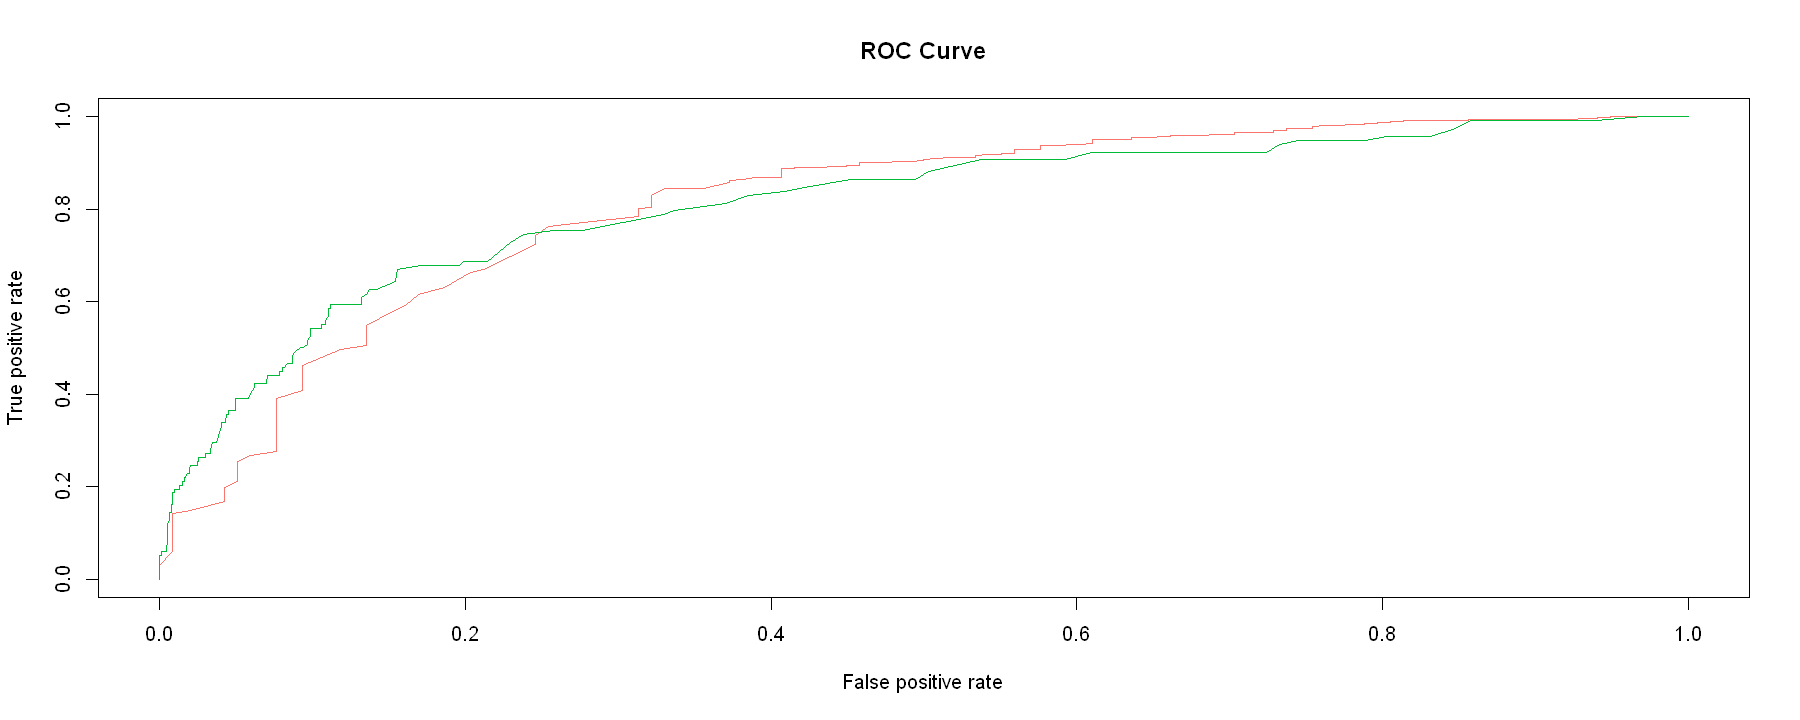

In [601]:
#  import ROCR package for ROC curve plotting - AUC is 81.1% with resampling, improvement from earlier model
library(ROCR)
# Calculate the probability of new observations belonging to each class
prediction_gb_up_roc_curve <- gb_df_up

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_gb_up_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.gb.valid.up <- performance(pred, measure = "auc")
 print(auc.gb.valid.up@y.values)
 }

In [602]:
# calculate accuracy metric on validation set - 85.4% without resampling, decrease from earlier model
gb_acc_valid_up <- accuracy(valid_processed$subscribe, gb.pred2.up)
gb_acc_valid_up

[1] 0.8542857

[1] 0.5932203

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.5.1. Support Vector Machine - WITHOUT RESAMPLING

In [604]:
library("e1071")

# train SVM on training set
svm = svm(formula = subscribe ~ ., 
                 data = train_processed[,-1], 
                 type = 'C-classification', 
                 kernel = 'linear',  #checked results from linear, polynomial and radial kernels and linear preformed best
                 probability=TRUE) 

In [605]:
# test on validation set 
svm.pred = predict(svm, newdata = valid_processed[,-1], probability=TRUE) 

In [606]:
# look at the confusion matrix
cm = table(valid_processed$subscribe, svm.pred) 
cm

   svm.pred
      0   1
  0 919  13
  1  94  24

In [607]:
# check if output of the model is in the form required 
head(attr(svm.pred, "probabilities"))

0,1
0.9039515,0.09604854
0.9039516,0.09604842
0.9039925,0.09600746
0.9039890,0.09601097
0.9039569,0.09604309
0.9039519,0.09604811


[[1]]
[1] 0.6173711

[[1]]
[1] 0.6173711



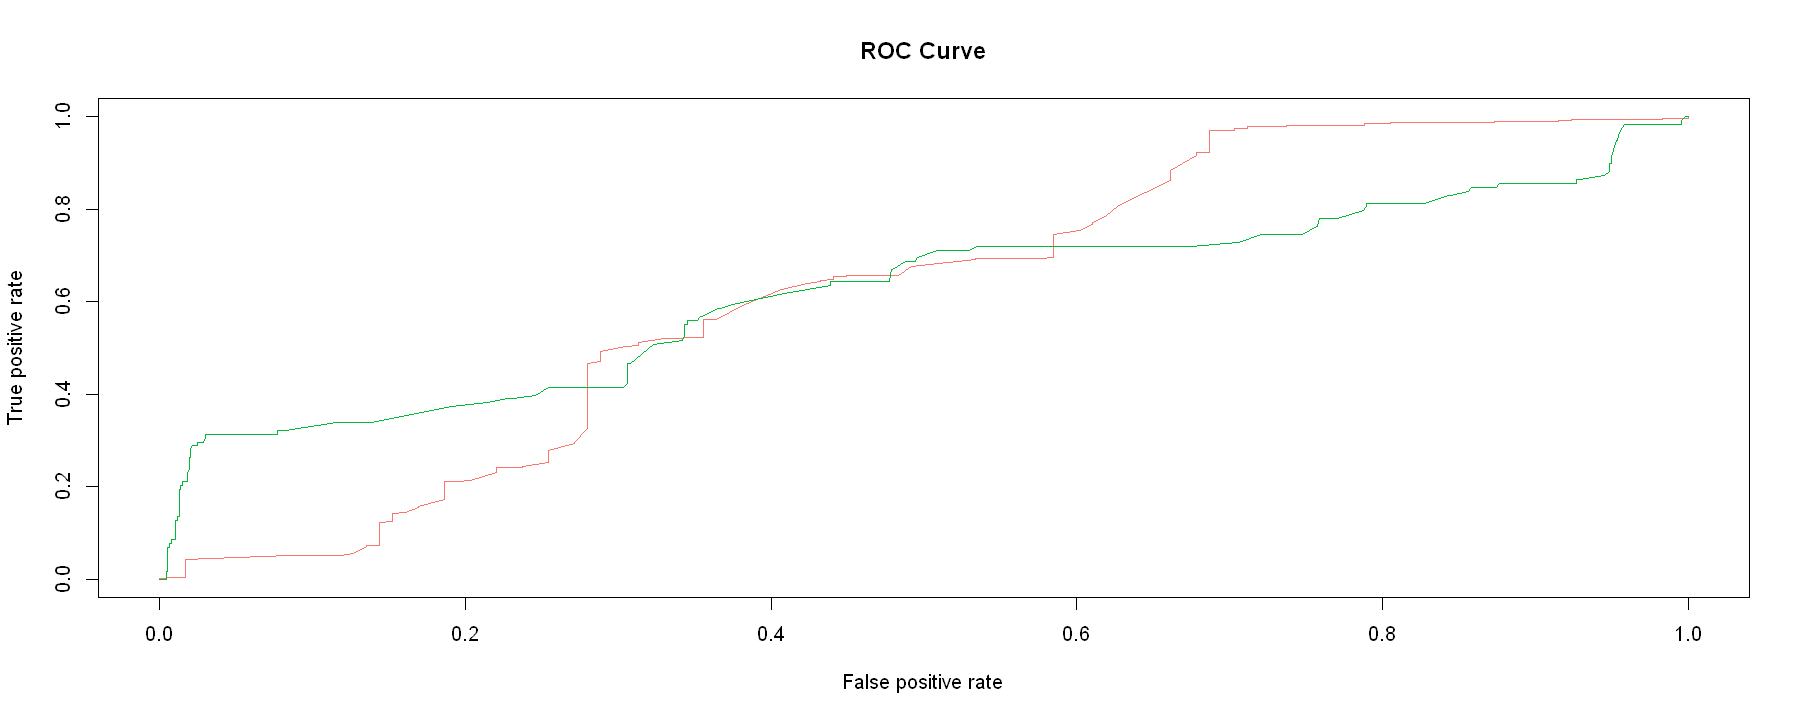

In [608]:
#  import ROCR package for ROC curve plotting - AUC is 61.7% without resampling
library(ROCR)
# Calculate the probability of new observations belonging to each class
prediction_svm_roc_curve <- predict(svm, newdata = valid_processed[,-1], probability=TRUE) 
prediction_svm_roc_curve <- attr(prediction_svm_roc_curve, "probabilities")
colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_svm_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.svm.valid <- performance(pred, measure = "auc")
 print(auc.svm.valid@y.values)
 }

In [609]:
# calculate accuracy metric on validation set - 89.8% accuracy without resampling
svm_acc_valid <- accuracy(valid_processed$subscribe, svm.pred)
svm_acc_valid


[1] 0.8980952

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

### 4.5.2. Support Vector Machine - WITH RESAMPLING

In [611]:
# resample the data in the train set using SMOTE - makes the classes more balanced 
# undersamples majority class (0) and oversamples minority class (1)
set.seed(1)
train_processed$subscribe <- as.factor(train_processed$subscribe)
up_train <- SMOTE(subscribe ~ ., data  = train_processed[, -1])                         
table(up_train$subscribe) 

Installing package into 'C:/Users/skamal/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'DMwR' is in use and will not be installed"


   0    1 
2284 1713 

In [612]:
# train SVM model on resampled data 
svm.up = svm(formula = subscribe ~ ., 
                 data = up_train[,-1], 
                 type = 'C-classification', 
                 kernel = 'linear',
                 probability=TRUE) 

In [613]:
# test on the validation set 
svm.pred.up = predict(svm.up, newdata = valid_processed[,-1]) 

In [614]:
# look at the confusion matrix 
cm = table(valid_processed$subscribe, svm.pred.up) 
cm

   svm.pred.up
      0   1
  0 805 127
  1  48  70

[[1]]
[1] 0.7800975

[[1]]
[1] 0.7800975



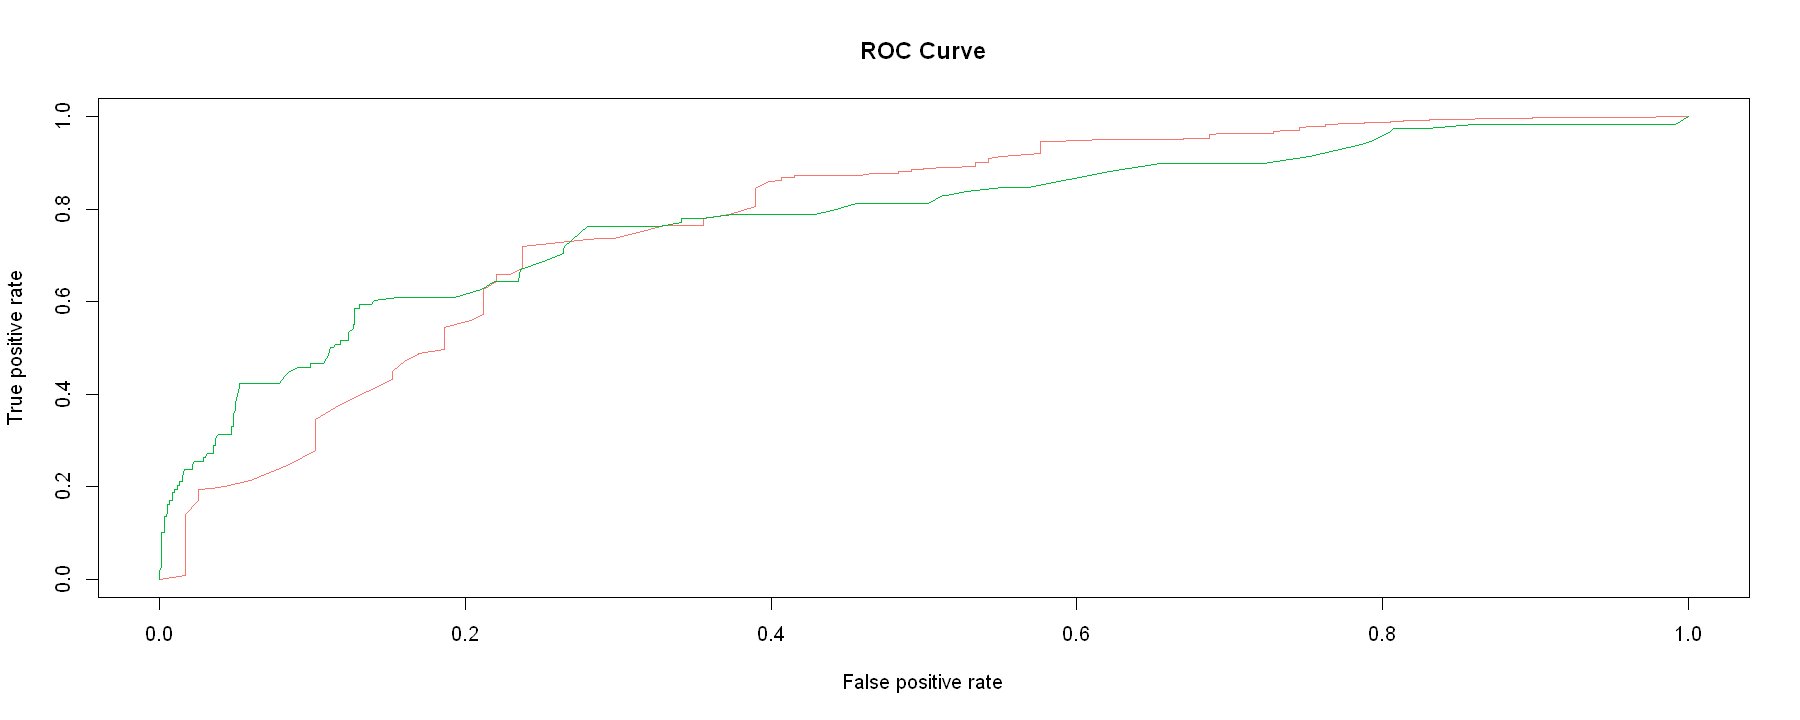

In [615]:
#  import ROCR package for ROC curve plotting - AUC goes up from 64% without resampling to 78% with resampling
library(ROCR)

# Calculate the probability of new observations belonging to each class
prediction_svm_up_roc_curve <- predict(svm.up, newdata = valid_processed[,-1], probability=TRUE) 
prediction_svm_up_roc_curve <- attr(prediction_svm_up_roc_curve, "probabilities")
colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(valid_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(valid_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_svm_up_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 if (i==1)
 {
     plot(perf,main="ROC Curve",col=colours[i]) 
 }
 else
 {
     plot(perf,main="ROC Curve",col=colours[i],add=TRUE) 
 }
 # Calculate the AUC and print it to screen
 auc.svm.valid.up <- performance(pred, measure = "auc")
 print(auc.svm.valid.up@y.values)
 }

In [616]:
# calculate accuracy metric on validation set - 83% accuracy with resampling, decrease from earlier model
svm_acc_valid_up <- accuracy(valid_processed$subscribe, svm.pred.up)
svm_acc_valid_up

[1] 0.8333333

Warning message in mean.default(predicted[actual == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

Warning message in mean.default(actual[predicted == 1]):
"argument is not numeric or logical: returning NA"

[1] NA

[1] 1

## 5.0. Experiment 2 - Testing Models on Test Set

In [617]:
# COMPARE ALL MODELS (WITH AND WITHOUT RESAMPLING) ON TEST SET 
# TOTAL OF TEN MODELS 

### 5.1. Logistic Regression - TEST MODELS WITH AND WITHOUT RESAMPLING

In [618]:
# LOGISTIC REGRESSION WITH AND WITHOUT SAMPLING

# test model without resampling
log.pred.test = (predict(log, newdata = test_processed[, -1]))
# if probabibility is > 0.5 consider as subscribe
log.pred2.test <- ifelse(log.pred.test > 0.5,1,0)

# test model with resampling
log.pred.test.up = plogis(predict(log.up, newdata = test_processed[, -1]))
# if probabibility is > 0.5 consider as subscribe
log.pred2.test.up <- ifelse(log.pred.test.up > 0.5,1,0)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [619]:
# transform to get probabilities 

# without resampling
log_df_test <- data.frame(log.pred.test)
log_df_test$one <- log_df_test$log.pred.test
log_df_test$zero <- 1 - log_df_test$log.pred.test
log_df_test <- log_df_test[-1]
log_df_test[, '0'] <- log_df_test[, 'zero'] 
log_df_test[, '1'] <- log_df_test[, 1]
log_df_test <- log_df_test[-1]
log_df_test <- log_df_test[-1]

# with resampling

log_df_test_up <- data.frame(log.pred.test.up)
log_df_test_up$one <- log_df_test_up$log.pred.test.up
log_df_test_up$zero <- 1 - log_df_test_up$log.pred.test.up
log_df_test_up <- log_df_test_up[-1]
log_df_test_up[, '0'] <- log_df_test_up[, 'zero'] 
log_df_test_up[, '1'] <- log_df_test_up[, 1]
log_df_test_up <- log_df_test_up[-1]
log_df_test_up <- log_df_test_up[-1]

#### 5.1.1 Logistic Model - Test Set - Without Resampling

In [620]:
# test logistic regression without resampling
# AUC is 83% without resampling

# Calculate the probability of new observations belonging to each class

prediction_log_test_roc_curve <- log_df_test

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_log_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.log.test <- performance(pred, measure = "auc")
 print(auc.log.test@y.values)
 }

[[1]]
[1] 0.831155

[[1]]
[1] 0.831155



In [621]:
# calculate accuracy on test set - 88.7% accuracy for logit model without resampling
log_acc_test <- accuracy(test_processed$subscribe, log.pred2.test)
log_acc_test

[1] 0.887619

[1] 0.1729323

[1] 0.7419355

[1] 1

#### 5.1.2 Logistic Model - Test Set - With Resampling

In [622]:
# test logistic regression with resampling
# AUC is 82.5% with resampling, slight decrease from 83% witout resamping

# Calculate the probability of new observations belonging to each class
prediction_logup_test_roc_curve <- log_df_test_up

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_logup_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.log.test.up <- performance(pred, measure = "auc")
 print(auc.log.test.up@y.values)
 }

[[1]]
[1] 0.8257107

[[1]]
[1] 0.8257107



In [623]:
# calculate accuracy on test set - 84.2% accuracy for logit model with resampling, decrease from model without resampling
log_acc_test_up <- accuracy(test_processed$subscribe, log.pred2.test.up)
log_acc_test_up


[1] 0.8419048

[1] 0.6766917

[1] 0.4225352

[1] 1

#### 5.1.3 Logistic Model - Predict on Holdout set 

In [624]:
# PREDICT ON THE HOLDOUT SET

# PREDICT LOGIT WITHOUT RESAMPLING
log_pred_holdout <- plogis(predict(log, newdata=test_holdout_processed[, -1]))

# PREDICT LOGIT WITH RESAMPLING
log_pred_holdout_up <- plogis(predict(log.up, newdata=test_holdout_processed[, -1]))
head(log_pred_holdout_up)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

1         2         3         4         5         6 
0.2547278 0.2242430 0.7582300 0.2746488 0.1614553 0.2763700

In [625]:
# EXPORT FILES
output <- data.frame(client_id=test_holdout$client_id, subscribe=log_pred_holdout)
write.csv(output, 'C:/Users/skamal/Downloads/log_submission_noresample.csv', row.names=FALSE) # AUC 80.4 on kaggle

Warning message in file(file, ifelse(append, "a", "w")):
"cannot open file 'C:/Users/skamal/Downloads/log_submission_noresample.csv': Permission denied"

ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


In [ ]:
# EXPORT FILES
output2 <- data.frame(client_id=test_holdout$client_id, subscribe=log_pred_holdout_up)
write.csv(output2, 'C:/Users/skamal/Downloads/log_submission_resample.csv', row.names=FALSE) # AUC 80.1 on kaggle

### 5.2. Decision Tree - TEST MODELS WITH AND WITHOUT RESAMPLING

In [627]:
# Decision Tree 

# predict tree with no resample

tree_pred_test <- predict(classtree, newdata=test_processed[, -1], type='class')
tree_pred_proba_test <- predict(classtree, newdata=test_processed[, -1], type='vector')

# predict tree with resample

tree_pred_test_up <- predict(classtree.up, newdata=test_processed[, -1], type='class')
tree_pred_proba_test_up <- predict(classtree.up, newdata=test_processed[, -1], type='vector')

In [641]:
# decision tree AUC on test - without resampling
# AUC is 78.7% without oversampling

# Calculate the probability of new observations belonging to each class

prediction_tree_roc_curve_test <- predict(classtree,test_processed[, -1],type="vector")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_tree_roc_curve_test[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")

 # Calculate the AUC and print it to screen
 auc.tree.test <- performance(pred, measure = "auc")
 print(auc.tree.test@y.values)
 }

[[1]]
[1] 0.7878133

[[1]]
[1] 0.7878133



In [643]:
# decision tree AUC on test set - with resampling
# AUC is 81.7% with resampling

# Calculate the probability of new observations belonging to each class

prediction_treeup_roc_curve_test <- predict(classtree.up,test_processed[, -1],type="vector")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_treeup_roc_curve_test[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.tree.test <- performance(pred, measure = "auc")
 print(auc.tree.test@y.values)
 }

[[1]]
[1] 0.8178803

[[1]]
[1] 0.8178803



In [632]:
# calculate accuracy on test set - 
#without oversampling - 88.8% accuracy
tree_acc_test <- accuracy(test_processed$subscribe, tree_pred_test)
tree_acc_test

#with oversampling - 84.5% accuracy
tree_acc_test_up <- accuracy(test_processed$subscribe, tree_pred_test_up)
tree_acc_test_up

[1] 0.8885714

[1] 0.8457143

### 5.3. Random Forest - TEST MODELS WITH AND WITHOUT RESAMPLING

In [634]:
# test random forest model without resampling

rdf.pred.test = predict(rdf, newdata = test_processed[, -1], type='response')

# test random forest model with resampling

rdf.pred.test.up = predict(rdf_up, newdata = test_processed[, -1], type='response')

In [644]:
# random forest auc on test - without resampling
# AUC is 76.9% without resampling


prediction_rdf_roc_curve_test <- predict(rdf,test_processed[, -1],type="prob")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_rdf_roc_curve_test[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")

 # Calculate the AUC and print it to screen
 auc.rdf.test <- performance(pred, measure = "auc")
 print(auc.rdf.test@y.values)
 }

[[1]]
[1] 0.7695862

[[1]]
[1] 0.7695862



In [646]:
# random forest auc on test - with resampling
# AUC is 80.3% with resampling

# Calculate the probability of new observations belonging to each class

prediction_rdfup_roc_curve_test <- predict(rdf_up,test_processed[, -1],type="prob")

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_rdfup_roc_curve_test[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.rdf.test.up <- performance(pred, measure = "auc")
 print(auc.rdf.test.up@y.values)
 }

[[1]]
[1] 0.8032486

[[1]]
[1] 0.8032486



In [647]:
# calculate accuracy on test set - 
#without oversampling - 89% accuracy
rf_acc_test <- accuracy(test_processed$subscribe, rdf.pred.test)
rf_acc_test

#with oversampling - 84.1% accuracy
rf_acc_test_up <- accuracy(test_processed$subscribe, rdf.pred.test.up)
rf_acc_test_up

[1] 0.8904762

[1] 0.8419048

### 5.4. Gradient Boosting - TEST MODELS WITH AND WITHOUT RESAMPLING

In [648]:
# TEST GRADIENT BOOSTING MODELS 

# without oversampling

gb.pred.test = predict(gb , test_processed[, -1], n.trees = 1500, type='response')
gb.pred2.test <- ifelse(gb.pred.test > 0.5,1,0)

# with oversampling

gb.pred.test.up = predict(gb.up , test_processed[, -1], n.trees = 1500, type='response')
gb.pred2.test.up <- ifelse(gb.pred.test.up > 0.5,1,0)

Warning message in predict.gbm(gb.up, test_processed[, -1], n.trees = 1500, type = "response"):
"Number of trees not specified or exceeded number fit so far. Using 1000."

In [649]:
# convert output to correct form

gb_df_test <- data.frame(gb.pred.test)
gb_df_test$one <- gb_df_test$gb.pred.test
gb_df_test$zero <- 1 - gb_df_test$gb.pred.test
gb_df_test <- gb_df_test[-1]
gb_df_test[, '0'] <- gb_df_test[, 'zero'] 
gb_df_test[, '1'] <- gb_df_test[, 1]
gb_df_test <- gb_df_test[-1]
gb_df_test <- gb_df_test[-1]


gb_df_test_up <- data.frame(gb.pred.test.up)
gb_df_test_up$one <- gb_df_test_up$gb.pred.test.up
gb_df_test_up$zero <- 1 - gb_df_test_up$gb.pred.test.up
gb_df_test_up <- gb_df_test_up[-1]
gb_df_test_up[, '0'] <- gb_df_test_up[, 'zero'] 
gb_df_test_up[, '1'] <- gb_df_test_up[, 1]
gb_df_test_up <- gb_df_test_up[-1]
gb_df_test_up <- gb_df_test_up[-1]

In [650]:
#  GB AUC on test - AUC is 81.9% without resampling

prediction_gb_test_roc_curve <- gb_df_test

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_gb_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.gb.test <- performance(pred, measure = "auc")
 print(auc.gb.test@y.values)
 }

[[1]]
[1] 0.8198727

[[1]]
[1] 0.8198727



In [651]:
#  GB AUC on test - AUC is 82.2% with resampling, slight improvement from first model
prediction_gbup_test_roc_curve <- gb_df_test_up

colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_gbup_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.gb.test.up <- performance(pred, measure = "auc")
 print(auc.gb.test.up@y.values)
 }

[[1]]
[1] 0.8222793

[[1]]
[1] 0.8222793



In [652]:
# calculate accuracy on test set - 
#without resampling -89.3% accuracy
gb_acc_test <- accuracy(test_processed$subscribe, gb.pred2.test)
gb_acc_test

#with resampling - 86.4% accuracy
gb_acc_test_up <- accuracy(test_processed$subscribe, gb.pred2.test.up)
gb_acc_test_up

[1] 0.8933333

[1] 0.8647619

In [656]:
# PREDICT ON THE HOLDOUT SET

# PREDICT GB WITHOUT RESAMPLING

gb_pred_holdout <- predict(gb, newdata=test_holdout_processed[, -1], n.trees=1000, type='response')

# PREDICT GB WITH RESAMPLING
gb_pred_holdout_up <- predict(gb.up, newdata=test_holdout_processed[, -1], n.trees=1000, type='response')
head(gb_pred_holdout)
head(gb_pred_holdout_up)

[1] 0.05470913 0.05111294 0.28309616 0.05549990 0.04172100 0.05463855

[1] 0.1794644 0.2123167 0.5303058 0.2497731 0.2601498 0.2709570

In [657]:
# EXPORT FILES
output <- data.frame(client_id=test_holdout$client_id, subscribe=gb_pred_holdout)
write.csv(output, 'C:/Users/skamal/Downloads/gb_submission_noresample.csv', row.names=FALSE) 

In [658]:
# EXPORT FILES
output <- data.frame(client_id=test_holdout$client_id, subscribe=gb_pred_holdout_up)
write.csv(output, 'C:/Users/skamal/Downloads/gb_submission_resample.csv', row.names=FALSE) # AUC 81.3 on kaggle

### 5.5. Support Vector Machine - TEST MODELS  WITH AND WITHOUT RESAMPLING

In [659]:
# predict SVM on test set - without resampling
svm.pred.test = predict(svm, newdata = test_processed[,-1]) 

# predict SVM on test set - with resampling
svm.pred.test.up = predict(svm.up, newdata = test_processed[,-1]) 

In [660]:
#  SVM AUC on test - without resamping 65% AUC 


prediction_svm_test_roc_curve <- predict(svm, newdata = test_processed[,-1], probability=TRUE) 
prediction_svm_test_roc_curve <- attr(prediction_svm_test_roc_curve, "probabilities")
colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_svm_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.svm.test <- performance(pred, measure = "auc")
 print(auc.svm.test@y.values)
 }

[[1]]
[1] 0.6519174

[[1]]
[1] 0.6519174



In [661]:
#  SVM AUC on test - with resamping 78.9% AUC 


prediction_svmup_test_roc_curve <- predict(svm.up, newdata = test_processed[,-1], probability=TRUE) 
prediction_svmup_test_roc_curve <- attr(prediction_svmup_test_roc_curve, "probabilities")
colours <- c("#F8766D","#00BA38")

# Specify the different classes 
classes <- levels(as.factor(test_processed$subscribe))


for (i in 1:2)
{
 # Define which observations belong to class[i]
 true_values <- ifelse(test_processed$subscribe==classes[i],1,0)
 # Assess the performance of classifier for class[i]
 pred <- prediction(prediction_svmup_test_roc_curve[,i],true_values)
 perf <- performance(pred, "tpr", "fpr")
 # Calculate the AUC and print it to screen
 auc.svm.test.up <- performance(pred, measure = "auc")
 print(auc.svm.test.up@y.values)
 }

[[1]]
[1] 0.7893384

[[1]]
[1] 0.7893384



In [662]:
# calculate accuracy on test set - 
#without resampling - 88.4% accurcay
svm_acc_test <- accuracy(test_processed$subscribe, svm.pred.test)
svm_acc_test

#with resampling - 84.5% accuracy
svm_acc_test_up <- accuracy(test_processed$subscribe, svm.pred.test.up)
svm_acc_test_up

[1] 0.8847619

[1] 0.8457143